In [1]:
# This is a Python 3 script
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [31]:
# Format code for fortran code: FORMAT(I4,F10.3,F10.3)
def ConstructInputASURV(fitting_table, line1, line2, outdir, obj=None):
    from astropy.io import ascii
    import numpy as np

    data = ascii.read(fitting_table)
    
    # get line fitting results of a single object if specified
    if obj != None:
        data = data[data['Object'] == obj]
    
    
    # Restrict to only select the 1-D spectra
    data = data[data['Pixel_No.'] == 'c']
    
    data1 = data[data['Line'] == line1]
    data2 = data[data['Line'] == line2]
    
    # make sure the objects have both PACS and SPIRE data
    data1_filter = np.zeros_like(data1['Validity'].data, dtype='bool')
    for i in range(len(data1)):
        if data1['Object'][i] in data2['Object'].data:
            data1_filter[i] = True

    data2_filter = np.zeros_like(data2['Validity'].data, dtype='bool')
    for i in range(len(data2)):
        if data2['Object'][i] in data1['Object'].data:
            data2_filter[i] = True
    
    data1 = data1[data1_filter]
    data2 = data2[data2_filter]
    
    # replace the non-detection to upper limit
    def FindUpperLimit(table):
        upperlimit_flag = np.empty_like(table['Str(W/cm2)'].data, dtype=int)
        linestr = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        linestr_unc = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        
        for i in range(len(table)):
            # for line fluxes with SNR < 3 or not able to fit properly
            # determine the SNR threshold based on modules (PACS or SPIRE)
            if table['ObsWL(um)'][i].astype('float') >= 196:
                snr_threshold = 4.0
#                 print('Customized SNR threshold is used')
            else:
                snr_threshold = 3.0
            if (table['Validity'][i].astype('float') == '0') or (table['SNR'][i].astype('float') < snr_threshold):
                upperlimit_flag[i] = -1
                linestr[i] = table['Noise(W/cm2/um)'][i].astype('float')*table['FWHM(um)'][i].astype('float')*1.064*3
                linestr_unc[i] = -1
            else:
                upperlimit_flag[i] = 0
                linestr[i] = table['Str(W/cm2)'][i].astype('float')
                linestr_unc[i] = table['Sig_str(W/cm2)'][i].astype('float')
            
        # convert the flux unit from W/cm2 to W/m2
        linestr = linestr*1e4
        linestr_unc[linestr_unc != -1] = linestr_unc[linestr_unc != -1]*1e4
        
        return upperlimit_flag, linestr, linestr_unc

    ulf1, linestr1, linestr_unc1 = FindUpperLimit(data1)
    ulf2, linestr2, linestr_unc2 = FindUpperLimit(data2)
    
    # check size
    if len(linestr1) != len(linestr2):
        print('The sizes of two arrays are inconsistent.')
        return None
    
#     For bivariate data:

#     3 : Both Independent and Dependent Variables are Lower Limits
#     2 : Only independent Variable is a Lower Limit
#     1 : Only Dependent Variable is a Lower Limit
#     0 : Detected Point
#     -1 : Only Dependent Variable is an Upper Limit
#     -2 : Only Independent Variable is an Upper Limit
#     -3 : Both Independent and Dependent Variables are Upper Limits

    # Define data1 as the independent variable, and data2 as the dependent variable.
    ulf1 = ulf1*2
    ulf = ulf1+ulf2
    
    # writing out
    foo = open(outdir+'co.dat', 'w')
#     foo.write('# '+line1+' and '+line2+'\n')
#     foo.write('# flux in 10^-18 W/m2 unit. \n')
    for i in range(len(linestr1)):
        foo.write('{:>4d}{:>10.3e}{:>10.3e} \n'.format(ulf[i], linestr1[i], linestr2[i]))
    foo.close()
    
    # if no detection found, throw a flag
    flag = True
    if not 0 in ulf:
        flag = False
    return flag

In [32]:
def RunandParseASURV(code_dir, outdir):
    import os
    import subprocess
    import sys
    
    ON_POSIX = 'posix' in sys.builtin_module_names
    # claer out previous output to prevent seg fault
    if os.path.exists(code_dir+'co.out'):
        os.remove(code_dir+'co.out')

#     p = subprocess.call([code_dir+'asurv_code'])
    p = subprocess.Popen([code_dir+'asurv_code_static'], stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, bufsize=1, close_fds=ON_POSIX)
#     p.communicate()
    print(p.stdout.readlines()[-1])
    print(p.stderr.readlines())
    
    out = open(code_dir+'co.out', 'r').read().splitlines()

    # [print(line) for line in out]

    # find the result about generalized Kendall's Tau, and Spearman's Rho
    for line in out:
        if 'Z-VALUE' in line:
            tau_i = out.index(line)
        if 'SPEARMANS RHO =' in line:
            spear_rho = out.index(line)
    
    kendall = (float(out[tau_i].split('=')[-1].strip()), float(out[tau_i+1].split('=')[-1].strip()))
    spearman = (float(out[spear_rho].split('=')[-1].strip()), float(out[spear_rho+1].split(' ')[12]))
    line1, line2 = out[8].split('AND')[0].strip(), out[8].split('AND')[1].strip()
#     print(kendall, spearman)
#     os.rename(code_dir+'co.out', outdir+line1+'_'+line2+'.out')
#     os.remove(code_dir+'co.out')

    return kendall, spearman


## Single line pair test

In [19]:
fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
line1 = 'p-H2O3_31-2_20'
line2 = 'o-H2O3_30-2_21'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
ConstructInputASURV(fitting_table, line1, line2, outdir)
k, s = RunandParseASURV(code_dir, outdir)
print(k,s)

b'                           PROBLEMS ARE FINISHED\n'
[]
(4.579, 4.678e-06) (1.0, 1.3072e-05)


In [20]:
import numpy as np
((20-3)/1.06)**0.5*0.5*np.log((1+s[0])/(1-s[0]))

ZeroDivisionError: float division by zero

In [33]:
data = ascii.read(fitting_table)
selector = (data['Validity'] == 1) & (data['SNR'] >= 3) & (data['Pixel_No.'] == 'c')
line = 'p-H2O1_11-0_00'
print(data[(data['Line'] == line) & selector])

  Object        Line      LabWL(um) ObsWL(um) ... Pixel_No. Blend Validity
---------- -------------- --------- --------- ... --------- ----- --------
      B1-a p-H2O1_11-0_00 269.27908 269.23086 ...         c     x        1
      B1-c p-H2O1_11-0_00 269.27908  269.2615 ...         c     x        1
      B335 p-H2O1_11-0_00 269.27908  269.2464 ...         c     x        1
     BHR71 p-H2O1_11-0_00 269.27908 269.27852 ...         c     x        1
GSS30-IRS1 p-H2O1_11-0_00 269.27908 269.24161 ...         c     x        1
 IRAS15398 p-H2O1_11-0_00 269.27908 269.29182 ...         c     x        1
     L1157 p-H2O1_11-0_00 269.27908 269.26043 ...         c     x        1
      L483 p-H2O1_11-0_00 269.27908 269.28235 ...         c     x        1
   L723-MM p-H2O1_11-0_00 269.27908 269.33737 ...         c     x        1
RCrA-IRS5A p-H2O1_11-0_00 269.27908 269.29488 ...         c     x        1
RCrA-IRS7B p-H2O1_11-0_00 269.27908 269.25763 ...         c     x        1
RCrA-IRS7C p-H2O1_11-0_00

## Plot the line fluxes of a given line pair

[None, None, None, None]

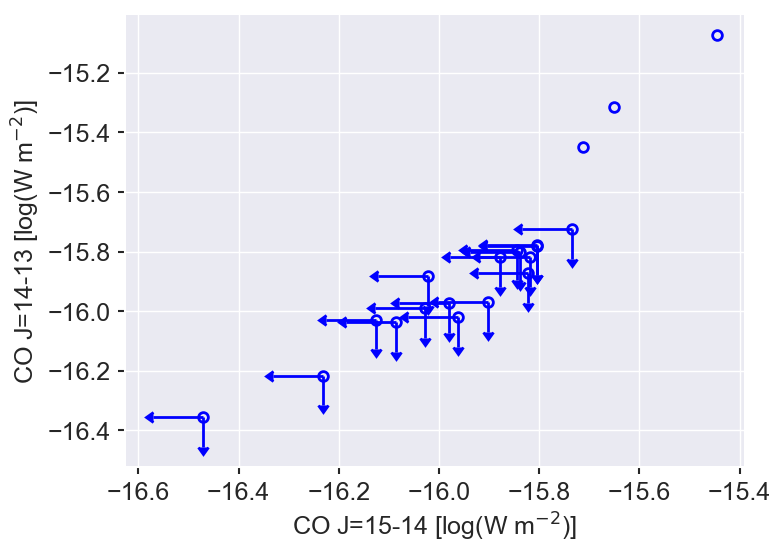

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
data = ascii.read(outdir+'co.dat', names=['ufl', line1, line2])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(data[line1][data['ufl'] == 0]), np.log10(data[line2][data['ufl'] == 0]), 'o',   mec='b', mfc='None',
         markeredgewidth=2)
# upper limit on x-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -2]), np.log10(data[line2][data['ufl'] == -2]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -2])), xuplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# # upper limit on y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -1]), np.log10(data[line2][data['ufl'] == -1]),
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -1])), uplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# upper limit on both x-axis and y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -3]), np.log10(data[line2][data['ufl'] == -3]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])), 
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])),
             xuplims=True, uplims=True, fmt='o', mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
ax.set_xlabel('CO J=15-14 [log(W m$^{-2}$)]', fontsize=18)
ax.set_ylabel('CO J=14-13 [log(W m$^{-2}$)]', fontsize=18)
ax.tick_params('both',labelsize=16,which='major')
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=5,length=2.5)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]

# fig.savefig('/Users/yaolun/test/CO43_CO2524.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Compare the difference of correlations between two adjacent lines at the edge of module

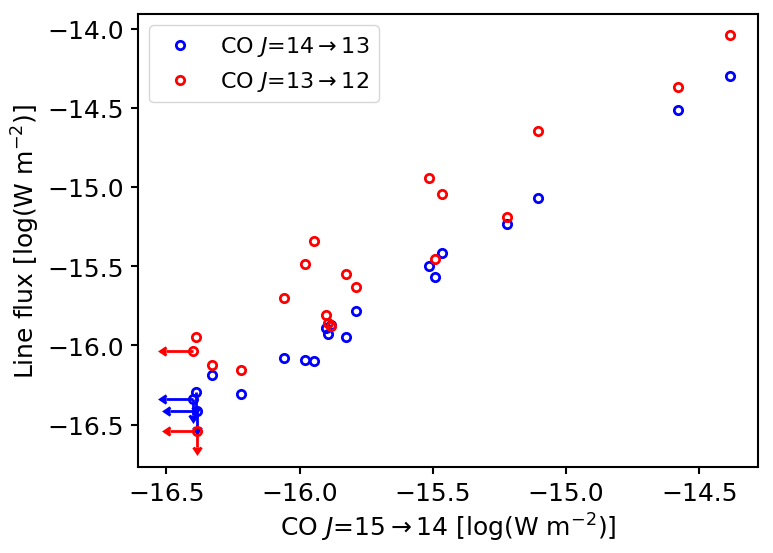

In [9]:
fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
line1 = 'CO15-14'
line2 = 'CO14-13'
line3 = 'CO13-12'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'

# CO 15-14 and CO 14-13
ConstructInputASURV(fitting_table, line1, line2, outdir)
data1413 = ascii.read(outdir+'co.dat', names=['ufl', line1, line2])

# CO 15-14 and CO 13-12
ConstructInputASURV(fitting_table, line1, line3, outdir)
data1312 = ascii.read(outdir+'co.dat', names=['ufl', line1, line3])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# CO 14-13
co1413, = ax.plot(np.log10(data1413[line1][data1413['ufl'] == 0]), np.log10(data1413[line2][data1413['ufl'] == 0]), 'o',   mec='b', mfc='None',
         markeredgewidth=2)
# upper limit on x-axis
ax.errorbar(np.log10(data1413[line1][data1413['ufl'] == -2]), np.log10(data1413[line2][data1413['ufl'] == -2]),
             xerr=np.array([0.1]*len(data1413[line1][data1413['ufl'] == -2])), xuplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# # upper limit on y-axis
ax.errorbar(np.log10(data1413[line1][data1413['ufl'] == -1]), np.log10(data1413[line2][data1413['ufl'] == -1]),
             yerr=np.array([0.1]*len(data1413[line1][data1413['ufl'] == -1])), uplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)
# upper limit on both x-axis and y-axis
ax.errorbar(np.log10(data1413[line1][data1413['ufl'] == -3]), np.log10(data1413[line2][data1413['ufl'] == -3]),
             xerr=np.array([0.1]*len(data1413[line1][data1413['ufl'] == -3])), 
             yerr=np.array([0.1]*len(data1413[line1][data1413['ufl'] == -3])),
             xuplims=True, uplims=True, fmt='o', mec='b', mfc='None',
             markeredgewidth=2, color='b', elinewidth=2)


# CO 13-12
co1312, = ax.plot(np.log10(data1312[line1][data1312['ufl'] == 0]), np.log10(data1312[line3][data1312['ufl'] == 0]), 'o',   mec='r', mfc='None',
         markeredgewidth=2)
# upper limit on x-axis
ax.errorbar(np.log10(data1312[line1][data1312['ufl'] == -2]), np.log10(data1312[line3][data1312['ufl'] == -2]),
             xerr=np.array([0.1]*len(data1312[line1][data1312['ufl'] == -2])), xuplims=True, fmt='o',   mec='r', mfc='None',
             markeredgewidth=2, color='r', elinewidth=2)
# # upper limit on y-axis
ax.errorbar(np.log10(data1312[line1][data1312['ufl'] == -1]), np.log10(data1312[line3][data1312['ufl'] == -1]),
             yerr=np.array([0.1]*len(data1312[line1][data1312['ufl'] == -1])), uplims=True, fmt='o',   mec='r', mfc='None',
             markeredgewidth=2, color='r', elinewidth=2)
# upper limit on both x-axis and y-axis
ax.errorbar(np.log10(data1312[line1][data1312['ufl'] == -3]), np.log10(data1312[line3][data1312['ufl'] == -3]),
             xerr=np.array([0.1]*len(data1312[line1][data1312['ufl'] == -3])), 
             yerr=np.array([0.1]*len(data1312[line1][data1312['ufl'] == -3])),
             xuplims=True, uplims=True, fmt='o', mec='r', mfc='None',
             markeredgewidth=2, color='r', elinewidth=2)

ax.legend([co1413, co1312], [r'CO $J$=14$\rightarrow$13', r'CO $J$=13$\rightarrow$12'],
          fontsize=16, loc='upper left')

ax.set_xlabel(r'CO $J$=15$\rightarrow$14 [log(W m$^{-2}$)]', fontsize=18)
ax.set_ylabel('Line flux [log(W m$^{-2}$)]', fontsize=18)
ax.tick_params('both',labelsize=16,which='major')
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=5,length=2.5)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]

fig.savefig('/Users/yaolun/research/cops-spire/co_correlation_edge_test.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Run all CO line pairs

In [ ]:
import itertools
from astropy.io import ascii
import numpy as np

# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

co_list = co_list

# print(list(itertools.combinations(co_list, 2)))

co_pair_list = list(itertools.combinations_with_replacement(co_list, 2))
print(len(co_pair_list))

foo = open(outdir+'co_correlation.txt', 'w')
foo.write('{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in co_pair_list:
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

## Use Pandas and Seaborn to visualize the results

In [2]:
%matplotlib inline

In [ ]:
def co_heatmap(col_name, fitting_table, label):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # create data 2d array
    j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])

    # j_up = j_up[:5]
    j_up = j_up[j_up <= 36]
    data = np.empty((len(j_up), len(j_up)))

    # read in the result
    table = ascii.read(outdir+'co_correlation.txt')

    for i in range(len(j_up)):
        for j in range(i, len(j_up)):
            selector1 = (table['Line1'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line2'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector2 = (table['Line2'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line1'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector = selector1 + selector2

            if not (table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector] == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan


    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    line_list = ['CO J='+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up))]
    dataset = pd.DataFrame(data=data, index=line_list[::-1], columns=line_list)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if col_name == 'Ken.z':
        vmax = 7.0
    else:
        vmax = None
    
    sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax)
    cax.set_ylabel(label, fontsize=18)

    ax.set_xlabel('J$_{up}$', fontsize=18)
    ax.set_ylabel('J$_{up}$', fontsize=18)

    fig.savefig('/Users/yaolun/test/co_heatmap_'+col_name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
diag_value = [np.nan,0,1,0]
labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\rho$',r'Spearman$\prime s$ probability']
fitting_table = outdir+'co_correlation.txt'
outdir = '/Users/yaolun/astro_tools/'

for i in range(len(col_name)):
    co_heatmap(col_name[i], fitting_table, labels[i])

## Run all line pairs

In [36]:
from tqdm import tqdm
import itertools
from astropy.io import ascii
import numpy as np

fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

line_list = np.hstack((co_list,np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                                         'p-H2O1_11-0_00','o-H2O1_10-1_01','o-H2O3_12-2_21','p-H2O2_02-1_11',
                                         'o-H2O3_03-2_12','o-H2O2_12-1_01',
                                         'p-H2O3_13-2_02','o-H2O3_12-3_03',
                                         'OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
                                         'OH2-0','OH3-1','HCO+7-6'])))

# print(list(itertools.combinations(co_list, 2)))

pair_list = list(itertools.combinations_with_replacement(line_list, 2))
print(len(pair_list))

foo = open(outdir+'all_correlation.txt', 'w')
foo.write('{:<16s}{:<16s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in tqdm(pair_list):
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

  0%|          | 0/1891 [00:00<?, ?it/s]

1891


  0%|          | 1/1891 [00:01<45:30,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 2/1891 [00:02<45:23,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 3/1891 [00:04<45:10,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 4/1891 [00:05<45:21,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 5/1891 [00:07<45:17,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 6/1891 [00:08<45:23,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 7/1891 [00:10<45:22,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 8/1891 [00:11<45:06,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  0%|          | 9/1891 [00:12<45:25,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 10/1891 [00:14<45:14,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 11/1891 [00:15<45:16,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 12/1891 [00:17<45:13,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 13/1891 [00:18<45:17,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 14/1891 [00:20<45:27,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 15/1891 [00:21<45:07,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 16/1891 [00:23<45:46,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 17/1891 [00:24<46:45,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 18/1891 [00:26<48:12,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 19/1891 [00:27<47:47,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 20/1891 [00:29<47:06,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 21/1891 [00:30<46:49,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 22/1891 [00:32<46:43,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|          | 23/1891 [00:33<46:36,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|▏         | 24/1891 [00:35<46:31,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|▏         | 25/1891 [00:36<46:35,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|▏         | 26/1891 [00:38<46:48,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|▏         | 27/1891 [00:39<46:24,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  1%|▏         | 28/1891 [00:41<46:17,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 29/1891 [00:42<46:50,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 31/1891 [00:46<47:51,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 38/1891 [00:56<45:35,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 39/1891 [00:57<46:15,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 40/1891 [00:59<45:43,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 41/1891 [01:00<45:37,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 42/1891 [01:02<45:11,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 43/1891 [01:03<44:55,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 44/1891 [01:05<44:41,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 45/1891 [01:06<44:22,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 46/1891 [01:07<44:26,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  2%|▏         | 47/1891 [01:09<44:38,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 48/1891 [01:10<44:57,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 49/1891 [01:12<45:31,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 50/1891 [01:13<45:17,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 51/1891 [01:15<45:21,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 52/1891 [01:16<45:24,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 53/1891 [01:18<45:10,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 54/1891 [01:19<44:51,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 55/1891 [01:21<45:10,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 56/1891 [01:22<45:55,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 57/1891 [01:24<48:26,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 58/1891 [01:26<48:41,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 59/1891 [01:27<48:56,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 60/1891 [01:29<48:16,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 61/1891 [01:30<47:09,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 62/1891 [01:32<45:55,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 63/1891 [01:33<45:16,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 64/1891 [01:35<44:46,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 65/1891 [01:36<44:16,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  3%|▎         | 66/1891 [01:37<44:19,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▎         | 67/1891 [01:39<43:59,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▎         | 68/1891 [01:40<43:47,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▎         | 69/1891 [01:42<44:01,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▎         | 70/1891 [01:43<43:56,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 71/1891 [01:45<44:05,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 72/1891 [01:46<43:42,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 73/1891 [01:48<43:36,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 74/1891 [01:49<43:32,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 75/1891 [01:50<43:40,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 76/1891 [01:52<44:12,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 77/1891 [01:53<43:41,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 78/1891 [01:55<43:26,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 79/1891 [01:56<43:27,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 80/1891 [01:58<43:32,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 81/1891 [01:59<43:50,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 82/1891 [02:01<44:25,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 83/1891 [02:02<44:32,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 84/1891 [02:04<44:45,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  4%|▍         | 85/1891 [02:05<44:50,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▍         | 86/1891 [02:07<44:55,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▍         | 87/1891 [02:08<44:42,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▍         | 88/1891 [02:10<44:43,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▍         | 89/1891 [02:11<44:51,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▍         | 91/1891 [02:14<44:05,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 98/1891 [02:24<42:41,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 99/1891 [02:26<42:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 100/1891 [02:27<43:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 101/1891 [02:28<43:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 102/1891 [02:30<42:59,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 103/1891 [02:31<43:22,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  5%|▌         | 104/1891 [02:33<43:50,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 105/1891 [02:34<43:48,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 106/1891 [02:36<44:29,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 107/1891 [02:37<44:33,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 108/1891 [02:39<44:42,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 109/1891 [02:40<44:32,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 110/1891 [02:42<44:35,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 111/1891 [02:43<44:50,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 112/1891 [02:45<44:26,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 113/1891 [02:46<43:58,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 114/1891 [02:48<43:45,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 115/1891 [02:49<43:42,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 116/1891 [02:51<43:33,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 117/1891 [02:52<43:08,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▌         | 118/1891 [02:54<42:52,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▋         | 119/1891 [02:55<42:47,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▋         | 120/1891 [02:57<44:33,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▋         | 121/1891 [02:58<44:06,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  6%|▋         | 122/1891 [03:00<43:32,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 123/1891 [03:01<43:16,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 124/1891 [03:03<42:59,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 125/1891 [03:04<42:48,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 126/1891 [03:05<43:20,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 127/1891 [03:07<43:16,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 128/1891 [03:08<43:25,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 129/1891 [03:10<43:49,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 130/1891 [03:11<44:08,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 131/1891 [03:13<44:27,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 132/1891 [03:15<45:02,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 133/1891 [03:16<45:00,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 134/1891 [03:18<45:16,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 135/1891 [03:19<45:10,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 136/1891 [03:21<45:02,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 137/1891 [03:22<44:35,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 138/1891 [03:24<44:20,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 139/1891 [03:25<44:08,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 140/1891 [03:27<44:43,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  7%|▋         | 141/1891 [03:28<44:35,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 142/1891 [03:30<44:15,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 143/1891 [03:31<43:59,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 144/1891 [03:33<43:44,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 145/1891 [03:34<43:53,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 146/1891 [03:36<44:25,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 147/1891 [03:37<43:56,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 148/1891 [03:39<43:23,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 150/1891 [03:42<43:09,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 157/1891 [03:52<41:05,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 158/1891 [03:53<41:43,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 159/1891 [03:55<42:39,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  8%|▊         | 160/1891 [03:56<43:20,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▊         | 161/1891 [03:58<43:58,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▊         | 162/1891 [04:00<44:02,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▊         | 163/1891 [04:01<44:14,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▊         | 164/1891 [04:03<43:46,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▊         | 165/1891 [04:04<43:32,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 166/1891 [04:06<44:10,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 167/1891 [04:07<43:49,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 168/1891 [04:09<43:37,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 169/1891 [04:10<43:23,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 170/1891 [04:12<43:48,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 171/1891 [04:13<43:49,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 172/1891 [04:15<43:50,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 173/1891 [04:16<43:35,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 174/1891 [04:18<43:39,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 175/1891 [04:19<43:33,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 176/1891 [04:21<44:30,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 177/1891 [04:22<44:07,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 178/1891 [04:24<43:51,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


  9%|▉         | 179/1891 [04:25<43:21,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 180/1891 [04:27<43:37,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 181/1891 [04:29<43:42,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 182/1891 [04:30<43:25,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 183/1891 [04:32<43:24,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 184/1891 [04:33<42:54,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 185/1891 [04:35<42:45,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 186/1891 [04:36<43:13,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 187/1891 [04:38<42:46,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 188/1891 [04:39<42:14,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|▉         | 189/1891 [04:41<41:53,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 190/1891 [04:42<42:11,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 191/1891 [04:44<42:17,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 192/1891 [04:45<42:00,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 193/1891 [04:46<41:37,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 194/1891 [04:48<41:39,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 195/1891 [04:49<42:19,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 196/1891 [04:51<42:58,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 197/1891 [04:53<42:59,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 10%|█         | 198/1891 [04:54<43:06,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 199/1891 [04:56<43:16,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 200/1891 [04:58<46:13,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 201/1891 [04:59<45:55,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 202/1891 [05:01<45:49,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 203/1891 [05:02<44:52,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 204/1891 [05:04<43:33,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 205/1891 [05:05<42:41,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 206/1891 [05:07<42:19,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█         | 208/1891 [05:10<41:12,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█▏        | 215/1891 [05:19<39:19,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█▏        | 216/1891 [05:21<39:46,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 11%|█▏        | 217/1891 [05:22<39:46,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 218/1891 [05:24<39:44,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 219/1891 [05:25<39:41,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 220/1891 [05:27<39:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 221/1891 [05:28<39:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 222/1891 [05:30<41:37,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 223/1891 [05:31<41:19,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 224/1891 [05:33<46:13,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 225/1891 [05:35<47:12,  1.70s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 226/1891 [05:37<45:58,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 227/1891 [05:39<50:24,  1.82s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 228/1891 [05:40<49:48,  1.80s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 229/1891 [05:42<47:57,  1.73s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 230/1891 [05:44<46:12,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 231/1891 [05:45<44:45,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 232/1891 [05:47<43:28,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 233/1891 [05:48<42:15,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 234/1891 [05:49<41:35,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 235/1891 [05:51<40:58,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 12%|█▏        | 236/1891 [05:52<40:56,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 237/1891 [05:54<40:19,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 238/1891 [05:55<40:21,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 239/1891 [05:57<40:14,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 240/1891 [05:58<40:29,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 241/1891 [06:00<40:19,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 242/1891 [06:01<40:22,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 243/1891 [06:03<41:02,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 244/1891 [06:04<41:01,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 245/1891 [06:06<40:24,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 246/1891 [06:07<40:10,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 247/1891 [06:08<39:52,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 248/1891 [06:10<39:36,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 249/1891 [06:11<39:28,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 250/1891 [06:13<39:24,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 251/1891 [06:14<39:52,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 252/1891 [06:16<40:39,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 253/1891 [06:17<40:32,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 254/1891 [06:19<40:27,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 13%|█▎        | 255/1891 [06:20<39:53,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▎        | 256/1891 [06:22<40:34,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▎        | 257/1891 [06:23<40:27,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▎        | 258/1891 [06:25<40:37,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▎        | 259/1891 [06:27<43:28,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▎        | 260/1891 [06:29<47:42,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 261/1891 [06:31<53:50,  1.98s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 262/1891 [06:33<53:48,  1.98s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 263/1891 [06:35<56:00,  2.06s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 265/1891 [06:39<51:48,  1.91s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 272/1891 [06:51<49:20,  1.83s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 273/1891 [06:53<47:51,  1.77s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 14%|█▍        | 274/1891 [06:54<45:31,  1.69s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 275/1891 [06:56<44:25,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 276/1891 [06:58<44:37,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 277/1891 [06:59<43:13,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 278/1891 [07:01<43:28,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 279/1891 [07:02<42:37,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 280/1891 [07:04<41:47,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 281/1891 [07:05<42:23,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 282/1891 [07:07<43:46,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▍        | 283/1891 [07:09<43:17,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 284/1891 [07:10<42:48,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 285/1891 [07:12<41:39,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 286/1891 [07:13<41:30,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 287/1891 [07:15<41:02,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 288/1891 [07:16<40:39,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 289/1891 [07:18<40:21,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 290/1891 [07:19<39:42,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 291/1891 [07:21<39:55,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 292/1891 [07:22<39:46,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 15%|█▌        | 293/1891 [07:24<39:43,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 294/1891 [07:25<39:46,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 295/1891 [07:27<40:03,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 296/1891 [07:28<41:44,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 297/1891 [07:30<41:49,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 298/1891 [07:32<41:46,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 299/1891 [07:33<41:11,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 300/1891 [07:35<40:27,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 301/1891 [07:36<41:02,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 302/1891 [07:38<39:56,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 303/1891 [07:39<39:03,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 304/1891 [07:40<38:43,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 305/1891 [07:42<38:20,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 306/1891 [07:43<38:26,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▌        | 307/1891 [07:45<37:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▋        | 308/1891 [07:46<37:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▋        | 309/1891 [07:48<37:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▋        | 310/1891 [07:49<37:25,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▋        | 311/1891 [07:50<37:28,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 16%|█▋        | 312/1891 [07:52<37:23,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 313/1891 [07:53<37:26,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 314/1891 [07:55<37:23,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 315/1891 [07:56<37:09,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 316/1891 [07:58<37:44,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 317/1891 [07:59<37:37,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 318/1891 [08:01<38:28,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 319/1891 [08:02<38:58,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 321/1891 [08:05<38:31,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 328/1891 [08:16<38:01,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 329/1891 [08:17<38:13,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 17%|█▋        | 330/1891 [08:19<41:16,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 331/1891 [08:21<41:57,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 332/1891 [08:22<40:42,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 333/1891 [08:24<39:49,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 334/1891 [08:25<39:04,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 335/1891 [08:27<38:31,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 336/1891 [08:28<38:26,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 337/1891 [08:30<38:17,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 338/1891 [08:31<38:01,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 339/1891 [08:33<37:46,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 340/1891 [08:34<37:49,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 341/1891 [08:36<40:14,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 342/1891 [08:38<43:32,  1.69s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 343/1891 [08:40<43:43,  1.69s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 344/1891 [08:41<43:40,  1.69s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 345/1891 [08:43<42:22,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 346/1891 [08:44<40:51,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 347/1891 [08:46<42:38,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 348/1891 [08:48<42:49,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 18%|█▊        | 349/1891 [08:49<41:50,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▊        | 350/1891 [08:51<40:33,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▊        | 351/1891 [08:52<40:16,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▊        | 352/1891 [08:54<41:14,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▊        | 353/1891 [08:56<40:59,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▊        | 354/1891 [08:58<46:17,  1.81s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 355/1891 [08:59<44:19,  1.73s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 356/1891 [09:01<42:11,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 357/1891 [09:02<40:29,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 358/1891 [09:04<39:12,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 359/1891 [09:05<38:20,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 360/1891 [09:07<37:35,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 361/1891 [09:08<37:20,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 362/1891 [09:09<37:04,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 363/1891 [09:11<36:56,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 364/1891 [09:12<37:27,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 365/1891 [09:14<37:27,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 366/1891 [09:15<37:56,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 367/1891 [09:17<37:58,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 19%|█▉        | 368/1891 [09:18<37:56,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 369/1891 [09:20<39:04,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 370/1891 [09:22<39:04,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 371/1891 [09:23<39:01,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 372/1891 [09:25<38:27,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 373/1891 [09:26<38:09,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 374/1891 [09:28<38:30,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|█▉        | 376/1891 [09:31<37:05,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|██        | 383/1891 [09:40<36:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|██        | 384/1891 [09:42<37:21,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|██        | 385/1891 [09:44<37:17,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|██        | 386/1891 [09:45<37:26,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 20%|██        | 387/1891 [09:47<37:26,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 388/1891 [09:48<37:27,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 389/1891 [09:49<37:00,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 390/1891 [09:51<36:37,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 391/1891 [09:52<36:51,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 392/1891 [09:54<36:35,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 393/1891 [09:55<36:24,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 394/1891 [09:57<36:46,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 395/1891 [09:58<36:14,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 396/1891 [10:00<36:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 397/1891 [10:01<36:02,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 398/1891 [10:03<35:51,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 399/1891 [10:04<35:37,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 400/1891 [10:05<35:23,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██        | 401/1891 [10:07<35:30,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██▏       | 402/1891 [10:08<35:22,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██▏       | 403/1891 [10:10<35:30,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██▏       | 404/1891 [10:11<35:24,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██▏       | 405/1891 [10:13<35:55,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 21%|██▏       | 406/1891 [10:14<36:07,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 407/1891 [10:16<36:19,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 408/1891 [10:17<35:52,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 409/1891 [10:18<35:33,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 410/1891 [10:20<35:16,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 411/1891 [10:21<35:23,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 412/1891 [10:23<35:15,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 413/1891 [10:24<35:08,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 414/1891 [10:25<34:56,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 415/1891 [10:27<35:20,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 416/1891 [10:28<36:00,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 417/1891 [10:30<35:53,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 418/1891 [10:31<35:57,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 419/1891 [10:33<36:06,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 420/1891 [10:34<35:58,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 421/1891 [10:36<36:25,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 422/1891 [10:37<36:33,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 423/1891 [10:39<36:25,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 424/1891 [10:40<36:31,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 22%|██▏       | 425/1891 [10:42<36:44,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 426/1891 [10:43<36:36,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 427/1891 [10:45<36:21,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 428/1891 [10:46<36:28,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 430/1891 [10:49<35:55,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 437/1891 [11:00<37:59,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 438/1891 [11:02<37:36,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 439/1891 [11:03<37:14,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 440/1891 [11:05<36:32,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 441/1891 [11:06<36:35,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 442/1891 [11:08<36:29,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 443/1891 [11:09<36:16,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 23%|██▎       | 444/1891 [11:11<36:12,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▎       | 445/1891 [11:12<36:13,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▎       | 446/1891 [11:14<36:29,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▎       | 447/1891 [11:15<36:26,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▎       | 448/1891 [11:17<36:12,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▎       | 449/1891 [11:18<36:15,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 450/1891 [11:20<36:05,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 451/1891 [11:21<36:06,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 452/1891 [11:23<35:36,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 453/1891 [11:24<35:31,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 454/1891 [11:26<35:34,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 455/1891 [11:27<36:41,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 456/1891 [11:29<36:27,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 457/1891 [11:30<35:48,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 458/1891 [11:32<35:30,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 459/1891 [11:33<35:31,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 460/1891 [11:35<35:28,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 461/1891 [11:36<35:13,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 462/1891 [11:38<34:59,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 24%|██▍       | 463/1891 [11:39<34:44,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 464/1891 [11:40<34:28,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 465/1891 [11:42<34:21,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 466/1891 [11:43<34:25,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 467/1891 [11:45<34:12,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 468/1891 [11:46<33:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 469/1891 [11:48<33:59,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 470/1891 [11:49<33:57,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 471/1891 [11:51<34:00,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▍       | 472/1891 [11:52<33:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 473/1891 [11:53<33:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 474/1891 [11:55<33:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 475/1891 [11:56<33:45,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 476/1891 [11:58<34:00,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 477/1891 [11:59<33:54,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 478/1891 [12:01<34:36,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 479/1891 [12:03<41:59,  1.78s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 480/1891 [12:06<46:07,  1.96s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 25%|██▌       | 481/1891 [12:07<44:32,  1.90s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 483/1891 [12:10<39:01,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 490/1891 [12:20<33:48,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 491/1891 [12:22<33:56,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 492/1891 [12:23<33:45,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 493/1891 [12:25<33:36,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 494/1891 [12:26<33:26,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 495/1891 [12:27<33:35,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▌       | 496/1891 [12:29<33:39,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▋       | 497/1891 [12:30<33:32,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▋       | 498/1891 [12:32<33:29,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▋       | 499/1891 [12:33<33:16,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▋       | 500/1891 [12:35<33:13,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 26%|██▋       | 501/1891 [12:36<33:17,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 502/1891 [12:37<33:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 503/1891 [12:39<33:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 504/1891 [12:40<33:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 505/1891 [12:42<33:11,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 506/1891 [12:43<33:24,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 507/1891 [12:45<33:14,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 508/1891 [12:46<33:06,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 509/1891 [12:48<32:55,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 510/1891 [12:49<32:45,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 511/1891 [12:50<32:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 512/1891 [12:52<32:52,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 513/1891 [12:53<33:07,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 514/1891 [12:55<32:51,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 515/1891 [12:56<32:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 516/1891 [12:58<34:49,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 517/1891 [12:59<34:50,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 518/1891 [13:01<34:40,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 519/1891 [13:02<34:16,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 27%|██▋       | 520/1891 [13:04<33:56,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 521/1891 [13:05<33:58,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 522/1891 [13:07<34:28,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 523/1891 [13:08<34:21,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 524/1891 [13:10<34:03,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 525/1891 [13:11<34:00,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 526/1891 [13:13<34:27,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 527/1891 [13:14<34:08,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 528/1891 [13:16<33:46,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 529/1891 [13:17<33:27,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 530/1891 [13:19<33:20,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 531/1891 [13:20<33:42,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 532/1891 [13:22<33:25,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 533/1891 [13:23<33:01,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 28%|██▊       | 535/1891 [13:26<32:43,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▊       | 542/1891 [13:36<32:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▊       | 543/1891 [13:37<32:09,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 544/1891 [13:39<32:10,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 545/1891 [13:40<31:47,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 546/1891 [13:42<32:22,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 547/1891 [13:43<32:09,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 548/1891 [13:45<32:09,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 549/1891 [13:46<32:00,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 550/1891 [13:48<31:55,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 551/1891 [13:49<31:49,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 552/1891 [13:50<31:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 553/1891 [13:52<31:53,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 554/1891 [13:53<31:51,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 555/1891 [13:55<31:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 556/1891 [13:56<31:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 29%|██▉       | 557/1891 [13:58<31:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 558/1891 [13:59<31:55,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 559/1891 [14:00<31:50,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 560/1891 [14:02<31:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 561/1891 [14:03<31:43,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 562/1891 [14:05<31:40,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 563/1891 [14:06<31:38,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 564/1891 [14:08<31:37,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 565/1891 [14:09<31:23,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 566/1891 [14:10<31:26,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|██▉       | 567/1891 [14:12<31:36,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 568/1891 [14:13<31:29,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 569/1891 [14:15<31:25,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 570/1891 [14:16<31:24,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 571/1891 [14:18<31:37,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 572/1891 [14:19<31:35,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 573/1891 [14:20<31:28,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 574/1891 [14:22<31:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 575/1891 [14:23<31:09,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 30%|███       | 576/1891 [14:25<31:34,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 577/1891 [14:26<31:44,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 578/1891 [14:28<31:49,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 579/1891 [14:29<31:40,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 580/1891 [14:30<31:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 581/1891 [14:32<31:30,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 582/1891 [14:33<31:22,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 583/1891 [14:35<31:16,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 584/1891 [14:36<31:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███       | 586/1891 [14:39<30:55,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███▏      | 593/1891 [14:49<30:19,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███▏      | 594/1891 [14:50<30:27,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 31%|███▏      | 595/1891 [14:52<30:30,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 596/1891 [14:53<30:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 597/1891 [14:55<30:56,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 598/1891 [14:56<31:16,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 599/1891 [14:58<32:45,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 600/1891 [14:59<31:56,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 601/1891 [15:01<31:33,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 602/1891 [15:02<31:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 603/1891 [15:03<30:59,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 604/1891 [15:05<30:43,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 605/1891 [15:06<30:39,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 606/1891 [15:08<30:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 607/1891 [15:09<30:45,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 608/1891 [15:11<30:30,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 609/1891 [15:12<30:30,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 610/1891 [15:13<30:20,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 611/1891 [15:15<30:22,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 612/1891 [15:16<30:23,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 613/1891 [15:18<30:25,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 32%|███▏      | 614/1891 [15:19<30:24,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 615/1891 [15:21<30:15,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 616/1891 [15:22<30:20,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 617/1891 [15:23<30:10,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 618/1891 [15:25<30:07,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 619/1891 [15:26<30:05,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 620/1891 [15:28<30:10,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 621/1891 [15:29<30:07,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 622/1891 [15:30<29:58,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 623/1891 [15:32<29:58,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 624/1891 [15:33<30:02,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 625/1891 [15:35<30:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 626/1891 [15:36<30:11,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 627/1891 [15:38<30:07,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 628/1891 [15:39<30:12,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 629/1891 [15:41<30:12,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 630/1891 [15:42<30:10,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 631/1891 [15:43<30:15,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 632/1891 [15:45<30:16,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 33%|███▎      | 633/1891 [15:46<30:07,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▎      | 634/1891 [15:48<30:04,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▎      | 636/1891 [15:51<29:37,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 643/1891 [16:00<28:51,  1.39s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 644/1891 [16:02<29:08,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 645/1891 [16:03<29:34,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 646/1891 [16:05<29:45,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 647/1891 [16:06<29:47,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 648/1891 [16:07<29:43,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 649/1891 [16:09<29:36,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 650/1891 [16:10<29:28,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 651/1891 [16:12<29:40,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 34%|███▍      | 652/1891 [16:13<29:31,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 653/1891 [16:15<29:31,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 654/1891 [16:16<29:18,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 655/1891 [16:17<29:10,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 656/1891 [16:19<29:17,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 657/1891 [16:20<29:27,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 658/1891 [16:22<29:15,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 659/1891 [16:23<29:07,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 660/1891 [16:25<29:06,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▍      | 661/1891 [16:26<29:09,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 662/1891 [16:27<29:15,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 663/1891 [16:29<29:10,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 664/1891 [16:30<29:06,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 665/1891 [16:32<29:02,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 666/1891 [16:33<29:13,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 667/1891 [16:35<28:59,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 668/1891 [16:36<29:01,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 669/1891 [16:37<29:00,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 670/1891 [16:39<28:55,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 35%|███▌      | 671/1891 [16:40<28:54,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 672/1891 [16:42<29:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 673/1891 [16:43<28:55,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 674/1891 [16:45<28:51,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 675/1891 [16:46<28:42,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 676/1891 [16:47<29:01,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 677/1891 [16:49<29:00,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 678/1891 [16:50<29:09,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 679/1891 [16:52<28:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 680/1891 [16:53<28:39,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 681/1891 [16:55<28:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 682/1891 [16:56<28:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 683/1891 [16:58<30:39,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 36%|███▌      | 685/1891 [17:01<29:23,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 692/1891 [17:10<27:56,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 693/1891 [17:12<28:12,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 694/1891 [17:13<28:18,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 695/1891 [17:15<28:10,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 696/1891 [17:16<28:23,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 697/1891 [17:17<28:25,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 698/1891 [17:19<28:20,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 699/1891 [17:20<28:26,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 700/1891 [17:22<28:11,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 701/1891 [17:23<28:11,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 702/1891 [17:25<28:00,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 703/1891 [17:26<28:06,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 704/1891 [17:27<28:21,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 705/1891 [17:29<28:11,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 706/1891 [17:30<28:19,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 707/1891 [17:32<28:20,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 708/1891 [17:33<28:10,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 37%|███▋      | 709/1891 [17:35<28:08,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 710/1891 [17:36<27:57,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 711/1891 [17:37<28:10,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 712/1891 [17:39<28:09,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 713/1891 [17:40<28:04,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 714/1891 [17:42<28:23,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 715/1891 [17:43<28:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 716/1891 [17:45<28:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 717/1891 [17:46<28:02,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 718/1891 [17:47<28:00,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 719/1891 [17:49<27:47,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 720/1891 [17:50<27:38,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 721/1891 [17:52<27:43,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 722/1891 [17:53<27:43,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 723/1891 [17:55<27:44,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 724/1891 [17:56<27:32,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 725/1891 [17:57<27:46,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 726/1891 [17:59<27:59,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 727/1891 [18:00<27:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 38%|███▊      | 728/1891 [18:02<27:39,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▊      | 729/1891 [18:03<27:30,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▊      | 730/1891 [18:05<27:22,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▊      | 731/1891 [18:06<27:26,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 733/1891 [18:09<27:14,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 740/1891 [18:18<26:32,  1.38s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 741/1891 [18:20<26:47,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 742/1891 [18:21<26:56,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 743/1891 [18:23<26:57,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 744/1891 [18:24<26:55,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 745/1891 [18:26<26:47,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 39%|███▉      | 746/1891 [18:27<27:12,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 747/1891 [18:28<27:08,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 748/1891 [18:30<27:02,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 749/1891 [18:31<26:56,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 750/1891 [18:33<26:53,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 751/1891 [18:34<26:45,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 752/1891 [18:35<26:50,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 753/1891 [18:37<26:52,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 754/1891 [18:38<26:49,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 755/1891 [18:40<26:44,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|███▉      | 756/1891 [18:41<27:07,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 757/1891 [18:43<27:45,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 758/1891 [18:44<27:55,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 759/1891 [18:46<28:07,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 760/1891 [18:47<27:49,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 761/1891 [18:49<27:54,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 762/1891 [18:50<28:20,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 763/1891 [18:52<28:15,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 764/1891 [18:53<27:58,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 40%|████      | 765/1891 [18:55<27:38,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 766/1891 [18:56<28:07,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 767/1891 [18:58<30:48,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 768/1891 [19:00<29:53,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 769/1891 [19:01<28:58,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 770/1891 [19:03<28:17,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 771/1891 [19:04<28:09,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 772/1891 [19:06<27:41,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 773/1891 [19:07<27:18,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 774/1891 [19:08<27:16,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 775/1891 [19:10<27:26,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 776/1891 [19:11<27:55,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 777/1891 [19:13<27:46,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 778/1891 [19:14<27:34,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 41%|████      | 780/1891 [19:17<26:59,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 787/1891 [19:27<27:10,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 788/1891 [19:29<27:06,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 789/1891 [19:30<27:11,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 790/1891 [19:32<27:06,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 791/1891 [19:33<27:19,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 792/1891 [19:35<27:08,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 793/1891 [19:36<27:04,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 794/1891 [19:38<27:03,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 795/1891 [19:39<26:46,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 796/1891 [19:41<26:42,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 797/1891 [19:42<26:56,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 798/1891 [19:44<26:51,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 799/1891 [19:45<26:56,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 800/1891 [19:47<26:55,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 801/1891 [19:48<26:50,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 802/1891 [19:50<26:47,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 42%|████▏     | 803/1891 [19:51<27:06,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 804/1891 [19:53<27:07,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 805/1891 [19:54<27:06,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 806/1891 [19:56<27:11,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 807/1891 [19:57<27:40,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 808/1891 [19:59<27:20,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 809/1891 [20:00<27:18,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 810/1891 [20:02<27:11,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 811/1891 [20:03<27:20,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 812/1891 [20:05<27:12,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 813/1891 [20:06<27:35,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 814/1891 [20:08<27:08,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 815/1891 [20:09<27:01,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 816/1891 [20:11<27:06,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 817/1891 [20:12<27:10,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 818/1891 [20:14<27:04,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 819/1891 [20:15<26:58,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 820/1891 [20:17<26:52,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 821/1891 [20:18<26:49,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 43%|████▎     | 822/1891 [20:20<26:32,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▎     | 823/1891 [20:21<26:27,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▎     | 824/1891 [20:23<26:23,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▎     | 826/1891 [20:26<25:59,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 833/1891 [20:36<25:04,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 834/1891 [20:37<25:23,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 835/1891 [20:39<25:27,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 836/1891 [20:40<25:33,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 837/1891 [20:42<25:53,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 838/1891 [20:43<25:51,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 839/1891 [20:45<25:57,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 840/1891 [20:46<25:39,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 44%|████▍     | 841/1891 [20:47<25:28,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 842/1891 [20:49<25:26,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 843/1891 [20:50<25:35,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 844/1891 [20:52<25:31,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 845/1891 [20:53<25:38,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 846/1891 [20:55<25:45,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 847/1891 [20:57<27:51,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 848/1891 [20:58<28:12,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 849/1891 [21:00<27:21,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▍     | 850/1891 [21:01<26:39,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 851/1891 [21:03<26:23,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 852/1891 [21:04<26:07,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 853/1891 [21:06<25:56,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 854/1891 [21:07<25:45,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 855/1891 [21:09<25:25,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 856/1891 [21:10<25:43,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 857/1891 [21:12<27:32,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 858/1891 [21:14<26:44,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 859/1891 [21:15<26:06,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 45%|████▌     | 860/1891 [21:16<26:00,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 861/1891 [21:18<25:48,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 862/1891 [21:19<25:37,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 863/1891 [21:21<25:21,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 864/1891 [21:22<25:11,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 865/1891 [21:24<25:20,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 866/1891 [21:25<25:05,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 867/1891 [21:27<26:19,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 868/1891 [21:29<28:01,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 869/1891 [21:30<27:12,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▌     | 871/1891 [21:33<26:18,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▋     | 878/1891 [21:44<27:03,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 46%|████▋     | 879/1891 [21:46<26:31,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 880/1891 [21:47<26:14,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 881/1891 [21:49<26:01,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 882/1891 [21:50<25:57,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 883/1891 [21:52<25:50,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 884/1891 [21:53<25:31,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 885/1891 [21:55<25:32,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 886/1891 [21:56<25:49,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 887/1891 [21:58<26:07,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 888/1891 [22:00<25:50,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 889/1891 [22:01<25:31,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 890/1891 [22:03<25:32,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 891/1891 [22:04<25:27,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 892/1891 [22:06<25:51,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 893/1891 [22:07<26:09,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 894/1891 [22:09<25:51,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 895/1891 [22:10<25:48,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 896/1891 [22:12<25:49,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 897/1891 [22:14<25:49,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 47%|████▋     | 898/1891 [22:15<25:56,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 899/1891 [22:17<27:07,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 900/1891 [22:20<32:02,  1.94s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 901/1891 [22:22<36:03,  2.19s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 902/1891 [22:24<33:34,  2.04s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 903/1891 [22:26<31:03,  1.89s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 904/1891 [22:27<31:07,  1.89s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 905/1891 [22:29<29:03,  1.77s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 906/1891 [22:30<27:22,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 907/1891 [22:32<26:32,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 908/1891 [22:33<25:39,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 909/1891 [22:35<24:52,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 910/1891 [22:36<24:37,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 911/1891 [22:38<24:20,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 912/1891 [22:39<24:03,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 913/1891 [22:41<23:55,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 48%|████▊     | 915/1891 [22:43<23:15,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 922/1891 [22:53<22:32,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 923/1891 [22:55<22:34,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 924/1891 [22:56<22:43,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 925/1891 [22:58<24:39,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 926/1891 [22:59<24:17,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 927/1891 [23:01<23:55,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 928/1891 [23:02<23:42,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 929/1891 [23:04<23:27,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 930/1891 [23:05<23:25,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 931/1891 [23:07<24:16,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 932/1891 [23:08<24:09,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 933/1891 [23:10<24:15,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 934/1891 [23:11<23:50,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 935/1891 [23:13<23:54,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 49%|████▉     | 936/1891 [23:14<23:39,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 937/1891 [23:16<23:30,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 938/1891 [23:17<23:20,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 939/1891 [23:19<23:17,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 940/1891 [23:20<23:19,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 941/1891 [23:21<23:21,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 942/1891 [23:23<24:42,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 943/1891 [23:25<25:28,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 944/1891 [23:27<25:05,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|████▉     | 945/1891 [23:28<24:56,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 946/1891 [23:30<24:45,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 947/1891 [23:31<25:24,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 948/1891 [23:33<26:05,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 949/1891 [23:35<26:06,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 950/1891 [23:36<25:25,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 951/1891 [23:38<24:43,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 952/1891 [23:39<24:07,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 953/1891 [23:41<23:49,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 50%|█████     | 954/1891 [23:42<23:44,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 955/1891 [23:44<23:28,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 956/1891 [23:45<23:19,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 958/1891 [23:48<23:21,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 965/1891 [23:59<23:41,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 966/1891 [24:01<23:27,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 967/1891 [24:02<23:49,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 968/1891 [24:04<23:41,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████     | 969/1891 [24:05<23:31,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████▏    | 970/1891 [24:07<23:23,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████▏    | 971/1891 [24:08<23:21,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████▏    | 972/1891 [24:10<23:18,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 51%|█████▏    | 973/1891 [24:11<23:04,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 974/1891 [24:13<22:56,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 975/1891 [24:14<22:56,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 976/1891 [24:16<22:54,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 977/1891 [24:17<22:59,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 978/1891 [24:19<23:10,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 979/1891 [24:20<23:06,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 980/1891 [24:22<23:02,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 981/1891 [24:23<22:57,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 982/1891 [24:25<22:52,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 983/1891 [24:26<22:31,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 984/1891 [24:28<22:36,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 985/1891 [24:29<22:40,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 986/1891 [24:31<22:25,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 987/1891 [24:32<22:18,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 988/1891 [24:34<22:11,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 989/1891 [24:35<21:48,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 990/1891 [24:37<21:43,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 991/1891 [24:38<21:32,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 52%|█████▏    | 992/1891 [24:39<21:30,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 993/1891 [24:41<21:29,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 994/1891 [24:42<21:26,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 995/1891 [24:44<21:49,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 996/1891 [24:45<22:02,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 997/1891 [24:47<22:14,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 998/1891 [24:48<22:44,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1000/1891 [24:52<23:53,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1007/1891 [25:03<23:17,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1008/1891 [25:05<22:42,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1009/1891 [25:06<22:05,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1010/1891 [25:08<21:45,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 53%|█████▎    | 1011/1891 [25:09<21:30,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▎    | 1012/1891 [25:10<21:25,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▎    | 1013/1891 [25:12<21:18,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▎    | 1014/1891 [25:13<21:03,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▎    | 1015/1891 [25:15<21:00,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▎    | 1016/1891 [25:16<20:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1017/1891 [25:18<20:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1018/1891 [25:19<20:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1019/1891 [25:20<20:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1020/1891 [25:22<20:50,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1021/1891 [25:23<20:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1022/1891 [25:25<20:46,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1023/1891 [25:26<20:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1024/1891 [25:28<20:48,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1025/1891 [25:29<20:51,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1026/1891 [25:31<20:47,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1027/1891 [25:32<20:51,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1028/1891 [25:33<20:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1029/1891 [25:35<20:36,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 54%|█████▍    | 1030/1891 [25:36<20:38,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1031/1891 [25:38<20:32,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1032/1891 [25:39<20:36,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1033/1891 [25:41<20:31,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1034/1891 [25:42<20:32,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1035/1891 [25:44<20:38,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1036/1891 [25:45<20:28,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1037/1891 [25:46<20:33,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1038/1891 [25:48<20:32,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▍    | 1039/1891 [25:49<20:27,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▌    | 1041/1891 [25:52<20:30,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▌    | 1048/1891 [26:02<20:19,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 55%|█████▌    | 1049/1891 [26:04<20:12,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1050/1891 [26:05<20:16,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1051/1891 [26:07<20:16,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1052/1891 [26:08<20:20,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1053/1891 [26:10<20:09,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1054/1891 [26:11<20:03,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1055/1891 [26:12<20:15,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1056/1891 [26:14<20:10,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1057/1891 [26:15<20:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1058/1891 [26:17<19:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1059/1891 [26:18<19:50,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1060/1891 [26:20<20:37,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1061/1891 [26:21<20:38,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1062/1891 [26:23<20:50,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▌    | 1063/1891 [26:24<20:32,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▋    | 1064/1891 [26:26<20:16,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▋    | 1066/1891 [26:29<20:06,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▋    | 1067/1891 [26:30<19:57,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 56%|█████▋    | 1068/1891 [26:32<20:01,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1069/1891 [26:33<20:13,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1070/1891 [26:34<20:01,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1071/1891 [26:36<19:54,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1072/1891 [26:37<19:43,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1073/1891 [26:39<20:12,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1074/1891 [26:40<20:04,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1075/1891 [26:42<20:10,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1076/1891 [26:43<20:16,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1077/1891 [26:45<20:13,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1078/1891 [26:46<19:57,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 57%|█████▋    | 1079/1891 [26:48<19:46,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1088/1891 [27:02<22:49,  1.71s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1089/1891 [27:04<24:34,  1.84s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1090/1891 [27:06<24:44,  1.85s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1091/1891 [27:07<23:15,  1.74s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1092/1891 [27:09<21:57,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1093/1891 [27:10<21:01,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1096/1891 [27:14<19:21,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1100/1891 [27:20<18:35,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1101/1891 [27:21<18:46,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1102/1891 [27:23<18:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1103/1891 [27:24<18:46,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1104/1891 [27:26<18:37,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 58%|█████▊    | 1106/1891 [27:28<18:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1112/1891 [27:37<18:59,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1113/1891 [27:39<18:57,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1114/1891 [27:40<18:52,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1115/1891 [27:42<19:13,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1116/1891 [27:43<19:12,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1117/1891 [27:45<19:17,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1118/1891 [27:46<19:23,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 59%|█████▉    | 1120/1891 [27:49<18:52,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1127/1891 [27:59<18:48,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1128/1891 [28:01<18:43,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1129/1891 [28:02<18:40,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1130/1891 [28:04<18:40,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1131/1891 [28:05<18:38,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1132/1891 [28:07<18:36,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1133/1891 [28:08<18:37,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|█████▉    | 1134/1891 [28:10<18:35,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1135/1891 [28:11<18:40,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1136/1891 [28:13<18:41,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1137/1891 [28:14<18:37,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1138/1891 [28:15<18:32,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1139/1891 [28:17<18:26,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1140/1891 [28:18<18:28,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1141/1891 [28:20<18:29,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1142/1891 [28:21<18:33,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 60%|██████    | 1143/1891 [28:23<18:26,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1145/1891 [28:26<18:08,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1146/1891 [28:27<18:18,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1147/1891 [28:29<18:12,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1148/1891 [28:30<17:58,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1149/1891 [28:32<17:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1150/1891 [28:33<17:45,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1151/1891 [28:34<17:44,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1152/1891 [28:36<17:41,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1153/1891 [28:37<17:34,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1154/1891 [28:39<17:25,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1155/1891 [28:40<17:29,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 61%|██████    | 1156/1891 [28:42<17:35,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1165/1891 [28:54<16:59,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1166/1891 [28:56<17:07,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1167/1891 [28:57<18:13,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1168/1891 [28:59<17:56,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1169/1891 [29:00<17:40,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1170/1891 [29:02<17:34,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1171/1891 [29:03<17:30,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1172/1891 [29:05<17:28,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1173/1891 [29:06<17:20,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1174/1891 [29:07<17:06,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1175/1891 [29:09<17:12,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1177/1891 [29:12<17:12,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1178/1891 [29:13<17:04,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1179/1891 [29:15<16:55,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1180/1891 [29:16<16:59,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 62%|██████▏   | 1181/1891 [29:17<16:55,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1183/1891 [29:20<16:54,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1184/1891 [29:22<16:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1185/1891 [29:23<16:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1186/1891 [29:25<16:53,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1187/1891 [29:26<16:51,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1188/1891 [29:28<16:57,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1189/1891 [29:29<16:53,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1190/1891 [29:30<16:57,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1191/1891 [29:32<16:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1192/1891 [29:33<16:45,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1193/1891 [29:35<16:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 63%|██████▎   | 1195/1891 [29:38<16:22,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▎   | 1202/1891 [29:47<15:58,  1.39s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▎   | 1203/1891 [29:49<16:06,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▎   | 1204/1891 [29:50<16:06,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▎   | 1205/1891 [29:52<16:13,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1206/1891 [29:53<16:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1207/1891 [29:54<16:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1208/1891 [29:56<16:14,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1209/1891 [29:57<16:20,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1210/1891 [29:59<16:19,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1211/1891 [30:00<16:19,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1212/1891 [30:02<16:18,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1213/1891 [30:03<16:13,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1214/1891 [30:04<16:07,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1215/1891 [30:06<16:04,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1216/1891 [30:07<15:58,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1217/1891 [30:09<16:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 64%|██████▍   | 1218/1891 [30:10<16:01,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1220/1891 [30:13<15:54,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1221/1891 [30:14<15:53,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1222/1891 [30:16<15:46,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1223/1891 [30:17<15:44,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1224/1891 [30:19<15:39,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1225/1891 [30:20<15:44,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1226/1891 [30:22<15:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1227/1891 [30:23<15:49,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1228/1891 [30:24<15:50,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▍   | 1229/1891 [30:26<15:44,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 65%|██████▌   | 1238/1891 [30:39<16:14,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1239/1891 [30:41<16:19,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1240/1891 [30:42<16:32,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1241/1891 [30:44<16:16,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1242/1891 [30:45<16:13,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1243/1891 [30:47<16:18,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1246/1891 [30:51<16:06,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1250/1891 [30:58<17:48,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1251/1891 [30:59<17:32,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▌   | 1252/1891 [31:01<17:13,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▋   | 1253/1891 [31:03<16:58,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▋   | 1254/1891 [31:04<16:32,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 66%|██████▋   | 1256/1891 [31:07<16:02,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1262/1891 [31:16<15:03,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1263/1891 [31:17<14:59,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1264/1891 [31:18<14:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1273/1891 [31:32<16:34,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1274/1891 [31:34<16:51,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1275/1891 [31:36<16:37,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 67%|██████▋   | 1276/1891 [31:37<16:47,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1277/1891 [31:39<16:25,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1278/1891 [31:40<16:14,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1279/1891 [31:42<16:04,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1280/1891 [31:44<15:57,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1281/1891 [31:45<15:40,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1282/1891 [31:46<15:23,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1283/1891 [31:48<15:26,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1285/1891 [31:51<15:42,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1286/1891 [31:53<15:46,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1287/1891 [31:54<15:41,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1288/1891 [31:56<15:20,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1289/1891 [31:57<15:21,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1291/1891 [32:00<15:18,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1292/1891 [32:02<15:13,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1293/1891 [32:03<15:18,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1294/1891 [32:05<15:03,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 68%|██████▊   | 1295/1891 [32:06<15:03,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▊   | 1296/1891 [32:08<14:55,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▊   | 1297/1891 [32:09<14:57,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▊   | 1298/1891 [32:11<14:44,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1307/1891 [32:24<14:11,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1308/1891 [32:25<14:10,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1309/1891 [32:27<14:16,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1310/1891 [32:28<14:10,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1311/1891 [32:30<13:59,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 69%|██████▉   | 1312/1891 [32:31<13:53,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1315/1891 [32:35<13:33,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1319/1891 [32:41<13:25,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1320/1891 [32:43<13:33,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1321/1891 [32:44<13:32,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1322/1891 [32:45<13:28,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|██████▉   | 1323/1891 [32:47<13:28,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|███████   | 1325/1891 [32:50<13:16,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|███████   | 1331/1891 [32:58<13:34,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 70%|███████   | 1333/1891 [33:01<13:20,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1340/1891 [33:11<12:46,  1.39s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1341/1891 [33:12<12:55,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1342/1891 [33:14<12:56,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1343/1891 [33:15<12:54,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1344/1891 [33:16<12:55,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1345/1891 [33:18<13:18,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1346/1891 [33:20<13:33,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████   | 1347/1891 [33:21<13:47,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████▏  | 1348/1891 [33:23<14:53,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████▏  | 1349/1891 [33:25<14:35,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████▏  | 1350/1891 [33:26<14:29,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████▏  | 1351/1891 [33:29<16:36,  1.85s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 71%|███████▏  | 1352/1891 [33:31<17:53,  1.99s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1353/1891 [33:33<17:29,  1.95s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1354/1891 [33:35<16:47,  1.88s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1355/1891 [33:36<16:33,  1.85s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1356/1891 [33:38<15:37,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1357/1891 [33:39<14:59,  1.68s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1358/1891 [33:41<14:27,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1359/1891 [33:43<14:23,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1360/1891 [33:44<14:31,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1361/1891 [33:46<14:09,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1362/1891 [33:47<13:49,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 72%|███████▏  | 1363/1891 [33:49<13:36,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1396/1891 [34:38<11:32,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1403/1891 [34:48<11:23,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1404/1891 [34:50<11:23,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1405/1891 [34:51<11:31,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1406/1891 [34:52<11:32,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 74%|███████▍  | 1407/1891 [34:54<11:37,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1413/1891 [35:03<11:21,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1414/1891 [35:04<11:21,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1415/1891 [35:05<11:20,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1416/1891 [35:07<11:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1417/1891 [35:08<11:17,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▍  | 1418/1891 [35:10<11:14,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▌  | 1419/1891 [35:11<11:11,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▌  | 1421/1891 [35:15<12:21,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▌  | 1424/1891 [35:19<11:39,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 75%|███████▌  | 1425/1891 [35:21<11:40,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1592/1891 [39:19<06:58,  1.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1593/1891 [39:20<06:59,  1.41s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1594/1891 [39:22<07:02,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1595/1891 [39:23<07:00,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1596/1891 [39:24<06:59,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 84%|████████▍ | 1597/1891 [39:26<06:59,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1598/1891 [39:27<07:02,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1599/1891 [39:29<06:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1600/1891 [39:30<06:58,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1601/1891 [39:32<06:57,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1602/1891 [39:33<06:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1603/1891 [39:34<06:53,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1604/1891 [39:36<06:51,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1605/1891 [39:37<06:52,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1606/1891 [39:39<06:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▍ | 1607/1891 [39:40<06:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1608/1891 [39:42<06:51,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1609/1891 [39:43<06:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1610/1891 [39:45<06:45,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1611/1891 [39:46<06:42,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1612/1891 [39:47<06:38,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1613/1891 [39:49<06:35,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1614/1891 [39:50<06:35,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1615/1891 [39:52<06:35,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 85%|████████▌ | 1616/1891 [39:53<06:33,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1617/1891 [39:55<06:33,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1618/1891 [39:56<06:30,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1619/1891 [39:57<06:31,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1620/1891 [39:59<06:29,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1621/1891 [40:00<06:26,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1622/1891 [40:02<06:24,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1623/1891 [40:03<06:23,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1624/1891 [40:05<06:21,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1625/1891 [40:06<06:20,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1626/1891 [40:07<06:16,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1627/1891 [40:09<06:16,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1628/1891 [40:10<06:16,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1629/1891 [40:12<06:14,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▌ | 1630/1891 [40:13<06:14,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▋ | 1631/1891 [40:15<06:13,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▋ | 1632/1891 [40:16<06:11,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▋ | 1633/1891 [40:17<06:09,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▋ | 1634/1891 [40:19<06:05,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 86%|████████▋ | 1635/1891 [40:20<06:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1636/1891 [40:22<06:04,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1637/1891 [40:23<06:03,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1638/1891 [40:25<06:02,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1639/1891 [40:26<06:00,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1640/1891 [40:28<06:02,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1641/1891 [40:29<05:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1642/1891 [40:30<05:57,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1643/1891 [40:32<05:56,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1644/1891 [40:33<05:52,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1645/1891 [40:35<05:52,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1646/1891 [40:36<05:48,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1647/1891 [40:38<05:48,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1648/1891 [40:39<05:47,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1649/1891 [40:40<05:44,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1650/1891 [40:42<06:08,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1651/1891 [40:44<06:08,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1652/1891 [40:45<06:23,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1653/1891 [40:48<07:12,  1.82s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 87%|████████▋ | 1654/1891 [40:50<07:12,  1.83s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1655/1891 [40:52<07:20,  1.87s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1656/1891 [40:53<07:04,  1.81s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1657/1891 [40:55<06:49,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1658/1891 [40:58<08:08,  2.10s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1659/1891 [41:00<08:21,  2.16s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1660/1891 [41:02<08:15,  2.15s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1661/1891 [41:05<09:12,  2.40s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1662/1891 [41:08<09:25,  2.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1663/1891 [41:09<08:21,  2.20s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1664/1891 [41:11<07:33,  2.00s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1665/1891 [41:12<07:00,  1.86s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1666/1891 [41:14<06:33,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1667/1891 [41:15<06:14,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1668/1891 [41:17<06:15,  1.69s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1669/1891 [41:19<06:00,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1670/1891 [41:20<05:57,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1671/1891 [41:22<05:50,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1672/1891 [41:23<05:43,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 88%|████████▊ | 1673/1891 [41:25<05:36,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▊ | 1674/1891 [41:26<05:31,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▊ | 1675/1891 [41:28<05:36,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▊ | 1676/1891 [41:29<05:32,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▊ | 1677/1891 [41:31<05:26,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▊ | 1678/1891 [41:32<05:22,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1679/1891 [41:34<05:16,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1680/1891 [41:35<05:14,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1681/1891 [41:37<05:12,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1682/1891 [41:38<05:11,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1683/1891 [41:40<05:17,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1684/1891 [41:42<05:28,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1685/1891 [41:43<05:40,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1686/1891 [41:45<05:49,  1.70s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1687/1891 [41:47<05:36,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1688/1891 [41:48<05:23,  1.59s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1689/1891 [41:50<05:11,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1690/1891 [41:51<05:08,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1691/1891 [41:53<05:00,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 89%|████████▉ | 1692/1891 [41:54<04:56,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1693/1891 [41:56<04:53,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1694/1891 [41:57<04:49,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1695/1891 [41:58<04:45,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1696/1891 [42:00<04:44,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1697/1891 [42:01<04:46,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1698/1891 [42:03<04:43,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1699/1891 [42:04<04:39,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1700/1891 [42:06<04:37,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|████████▉ | 1701/1891 [42:07<04:36,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1702/1891 [42:09<04:54,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1703/1891 [42:10<04:46,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1704/1891 [42:12<04:38,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1705/1891 [42:13<04:34,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1706/1891 [42:15<04:29,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1707/1891 [42:16<04:27,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1709/1891 [42:19<04:21,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1710/1891 [42:20<04:22,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 90%|█████████ | 1711/1891 [42:22<04:20,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1712/1891 [42:23<04:18,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1713/1891 [42:25<04:16,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1715/1891 [42:28<04:10,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1716/1891 [42:29<04:09,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1717/1891 [42:30<04:09,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1718/1891 [42:32<04:08,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1719/1891 [42:33<04:05,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1720/1891 [42:35<04:04,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1721/1891 [42:36<04:02,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1722/1891 [42:38<04:00,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1723/1891 [42:39<04:01,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1724/1891 [42:40<03:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████ | 1725/1891 [42:42<03:58,  1.43s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████▏| 1727/1891 [42:45<03:53,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████▏| 1728/1891 [42:46<03:51,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████▏| 1729/1891 [42:48<03:49,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 91%|█████████▏| 1730/1891 [42:49<03:48,  1.42s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1731/1891 [42:50<03:49,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1733/1891 [42:53<03:55,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1734/1891 [42:55<03:55,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1735/1891 [42:57<04:01,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1736/1891 [42:58<04:02,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1737/1891 [43:00<03:58,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1738/1891 [43:01<03:54,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1739/1891 [43:03<03:49,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1740/1891 [43:04<03:47,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1741/1891 [43:06<03:44,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1742/1891 [43:07<03:43,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1744/1891 [43:10<03:39,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1745/1891 [43:12<03:36,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1746/1891 [43:13<03:34,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1747/1891 [43:15<03:33,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 92%|█████████▏| 1748/1891 [43:16<03:31,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1750/1891 [43:19<03:27,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1751/1891 [43:20<03:26,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1752/1891 [43:22<03:24,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1753/1891 [43:23<03:23,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1754/1891 [43:25<03:21,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1755/1891 [43:26<03:19,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1756/1891 [43:28<03:19,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1757/1891 [43:29<03:17,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1758/1891 [43:31<03:15,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1760/1891 [43:34<03:09,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1761/1891 [43:35<03:09,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1762/1891 [43:37<03:08,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1763/1891 [43:38<03:07,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1764/1891 [43:39<03:05,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1766/1891 [43:43<03:08,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1767/1891 [43:44<03:10,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 93%|█████████▎| 1768/1891 [43:46<03:07,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▎| 1769/1891 [43:48<03:20,  1.64s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▎| 1770/1891 [43:49<03:13,  1.60s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▎| 1771/1891 [43:51<03:21,  1.68s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▎| 1772/1891 [43:53<03:25,  1.72s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1773/1891 [43:55<03:35,  1.82s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1775/1891 [43:59<03:51,  2.00s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1776/1891 [44:01<03:41,  1.93s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1777/1891 [44:03<03:27,  1.82s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1778/1891 [44:04<03:15,  1.73s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1779/1891 [44:06<03:06,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1781/1891 [44:09<02:53,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1782/1891 [44:10<02:49,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1783/1891 [44:12<02:48,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1784/1891 [44:13<02:44,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1785/1891 [44:15<02:42,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 94%|█████████▍| 1786/1891 [44:16<02:40,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1787/1891 [44:18<02:36,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1788/1891 [44:19<02:32,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1789/1891 [44:21<02:30,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1790/1891 [44:22<02:28,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1791/1891 [44:25<03:11,  1.92s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1792/1891 [44:27<03:20,  2.02s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1793/1891 [44:29<03:06,  1.91s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1794/1891 [44:30<02:51,  1.76s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1795/1891 [44:32<02:47,  1.74s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▍| 1796/1891 [44:34<02:45,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1797/1891 [44:35<02:39,  1.70s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1798/1891 [44:37<02:31,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1799/1891 [44:38<02:25,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1800/1891 [44:40<02:20,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1801/1891 [44:41<02:15,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1802/1891 [44:43<02:12,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1803/1891 [44:44<02:09,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1804/1891 [44:45<02:06,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 95%|█████████▌| 1805/1891 [44:47<02:04,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1806/1891 [44:48<02:02,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1807/1891 [44:50<02:00,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1808/1891 [44:51<02:01,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1809/1891 [44:53<02:03,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1810/1891 [44:55<02:06,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1811/1891 [44:56<02:02,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1812/1891 [44:58<02:07,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1814/1891 [45:01<01:56,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1815/1891 [45:02<01:53,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1816/1891 [45:04<01:51,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1817/1891 [45:06<02:03,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1818/1891 [45:08<02:06,  1.73s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1819/1891 [45:09<02:08,  1.78s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▌| 1820/1891 [45:11<02:09,  1.82s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▋| 1821/1891 [45:13<02:09,  1.85s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▋| 1822/1891 [45:15<02:06,  1.83s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▋| 1823/1891 [45:17<02:00,  1.77s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 96%|█████████▋| 1824/1891 [45:18<01:55,  1.73s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1825/1891 [45:20<01:50,  1.67s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1826/1891 [45:21<01:44,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1827/1891 [45:23<01:39,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1828/1891 [45:24<01:35,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1829/1891 [45:26<01:34,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1830/1891 [45:27<01:38,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1831/1891 [45:29<01:37,  1.63s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1832/1891 [45:31<01:35,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1833/1891 [45:32<01:31,  1.57s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1834/1891 [45:34<01:27,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1835/1891 [45:35<01:25,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1836/1891 [45:37<01:23,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1837/1891 [45:38<01:21,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1838/1891 [45:40<01:20,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1839/1891 [45:41<01:18,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1840/1891 [45:43<01:18,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1841/1891 [45:44<01:15,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1842/1891 [45:46<01:13,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 97%|█████████▋| 1843/1891 [45:47<01:12,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1844/1891 [45:49<01:10,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1845/1891 [45:50<01:09,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1846/1891 [45:52<01:07,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1847/1891 [45:53<01:05,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1848/1891 [45:55<01:03,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1849/1891 [45:56<01:01,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1850/1891 [45:58<01:01,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1851/1891 [45:59<00:58,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1852/1891 [46:00<00:56,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1853/1891 [46:02<00:55,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1854/1891 [46:03<00:53,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1855/1891 [46:05<00:52,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1856/1891 [46:06<00:50,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1857/1891 [46:08<00:49,  1.46s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1858/1891 [46:09<00:47,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1859/1891 [46:11<00:46,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1860/1891 [46:12<00:44,  1.45s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1861/1891 [46:13<00:43,  1.44s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 98%|█████████▊| 1862/1891 [46:15<00:42,  1.47s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▊| 1863/1891 [46:17<00:41,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▊| 1864/1891 [46:18<00:39,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▊| 1865/1891 [46:19<00:38,  1.48s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▊| 1866/1891 [46:21<00:37,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▊| 1867/1891 [46:23<00:36,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1868/1891 [46:24<00:34,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1869/1891 [46:26<00:36,  1.66s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1871/1891 [46:30<00:35,  1.75s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1872/1891 [46:31<00:32,  1.71s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1873/1891 [46:33<00:29,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1874/1891 [46:35<00:27,  1.61s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1875/1891 [46:36<00:25,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1876/1891 [46:38<00:23,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1877/1891 [46:39<00:21,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1878/1891 [46:41<00:20,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1879/1891 [46:42<00:18,  1.56s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1880/1891 [46:44<00:16,  1.53s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


 99%|█████████▉| 1881/1891 [46:45<00:15,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1882/1891 [46:47<00:13,  1.55s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1883/1891 [46:48<00:12,  1.54s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1884/1891 [46:50<00:10,  1.52s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1885/1891 [46:51<00:09,  1.51s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1886/1891 [46:53<00:07,  1.49s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1887/1891 [46:54<00:05,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1888/1891 [46:56<00:04,  1.50s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1889/1891 [46:58<00:03,  1.65s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|█████████▉| 1890/1891 [46:59<00:01,  1.62s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


100%|██████████| 1891/1891 [47:01<00:00,  1.58s/it]

b'                           PROBLEMS ARE FINISHED\n'
[]


In [5]:
from astropy.io import ascii
table = ascii.read(outdir+'all_correlation.txt')
print(table['Spr.rho'].min())
print(table['Line1'][table['Spr.rho'] < 0])
print(table['Line2'][table['Spr.rho'] < 0])

-0.242
 Line1 
-------
CO14-13
CO37-36
CO37-36
CO37-36
CO39-38
CO39-38
CO39-38
CO39-38
CO39-38
CO39-38
    Line2     
--------------
       CO39-38
         CO4-3
o-H2O3_03-2_12
o-H2O2_12-1_01
         CO4-3
         CO5-4
p-H2O2_02-1_11
o-H2O3_03-2_12
o-H2O2_12-1_01
p-H2O3_13-2_02


In [6]:
def general_heatmap(line_list, col_name, fitting_table, label, mod_name='', line_labels=None, suffix=''):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib import colors


    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))
    
    # read in the result
    table = ascii.read(outdir+'all_correlation.txt')

    data = np.empty((len(line_list), len(line_list)))
    
    for i in range(len(line_list)):
        for j in range(i, len(line_list)):
            selector1 = (table['Line1'] == line_list[i]) & \
                        (table['Line2'] == line_list[j])
            selector2 = (table['Line2'] == line_list[i]) & \
                        (table['Line1'] == line_list[j])
            selector = selector1 + selector2

            if not len((table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector]) == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan

    
    # if there is no line name labels given, use the line list name instead
    if line_labels is None:
        line_labels = line_list
                

    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    dataset = pd.DataFrame(data=data, index=line_labels[::-1], columns=line_labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cmap = "cubehelix"
    
    if col_name == 'Ken.z':
        vmax = 8.0
        vmin = 0.0
#         cmap = 'RdGy_r'
        cmap = 'RdYlBu_r'
        
        dataset[dataset >= vmax] = vmax
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax,
                    cbar_kws={'ticks':np.arange(1,vmax+1, dtype='int')},
                    norm=MidpointNormalize(midpoint=3,vmin=vmin, vmax=vmax), cmap=cmap)
#         sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
#                 vmin=vmin, cmap=cmap)
        
    elif col_name =='Spr.rho':
        # transform the correlation coefficient to the z-value
        dataset = ((20-3)/1.06)**0.5*0.5*np.log((1+dataset)/(1-dataset))
        
        vmax = 12.0
        vmin = 0.0
        
        dataset[np.isinf(dataset)] = vmax
        dataset[dataset >= vmax] = vmax
#         cmap = 'RdGy_r'
        cmap = 'RdYlBu_r'
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax,
                    cbar_kws={'ticks':np.arange(1,vmax+1, dtype='int')},
                    norm=MidpointNormalize(midpoint=3,vmin=vmin, vmax=vmax), cmap=cmap)
#         sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
#                 vmin=vmin, cmap=cmap)
    else:
        # calculate the cooresponding sigma level assuming a normal distribution
        dataset = dataset.replace(0.0, 1.0)
        dataset = (-2*np.log(dataset))**0.5
        vmax = 8
        vmin = 0
        sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
                vmin=vmin, cmap=cmap)

    
    cax.set_ylabel(label, fontsize=26, labelpad=10)
    cax.tick_params('both',labelsize=20)
    cax.minorticks_on()

    ax.tick_params('both',labelsize=20)
    
    # if only plot CO lines, color the tick labels based on the instrument
    if 'co' in suffix:
        color_list = ['k','r','b','b','k']
        # x-axis
        for i in range(len(ax.get_xticklabels())):
            if i <= 4:
                ax.get_xticklabels()[i].set_color(color_list[0])
            elif (i > 4) & (i <= 9):
                ax.get_xticklabels()[i].set_color(color_list[1])
            elif (i > 9) & (i <= 13):
                ax.get_xticklabels()[i].set_color(color_list[2])
            elif (i > 13) & (i <= 21):
                ax.get_xticklabels()[i].set_color(color_list[3])
            else:
                ax.get_xticklabels()[i].set_color(color_list[4])
        
        # y-axis
        for i in range(len(ax.get_yticklabels())):
            if i <= 4:
                ax.get_yticklabels()[i].set_color(color_list[0])
            elif (i > 4) & (i <= 9):
                ax.get_yticklabels()[i].set_color(color_list[1])
            elif (i > 9) & (i <= 13):
                ax.get_yticklabels()[i].set_color(color_list[2])
            elif (i > 13) & (i <= 21):
                ax.get_yticklabels()[i].set_color(color_list[3])
            else:
                ax.get_yticklabels()[i].set_color(color_list[4])

    if mod_name != '':
        mod_name = '_'+mod_name
    fig.savefig('/Users/yaolun/test/general_heatmap_'+col_name.replace('.','_')+mod_name+suffix+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

## only plot the lines reside in the same module

In [4]:
from astropy.io import ascii
import numpy as np                  

col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']

labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\,z$-value',r'Spearman$\prime s$ probability']
outdir = '/Users/yaolun/astro_tools/'
corr_table = outdir+'all_correlation.txt'

fitting_table = '/Volumes/SD-Mac/CDF_archive_v2/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'

# construct the line list
data = ascii.read(fitting_table)
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data['Line'].data)))))
j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])  
line_list_co = ['CO'+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up[j_up <= 36]))]
line_list_co.remove('CO33-32')
line_list_co.remove('CO31-30')
line_list = np.hstack((np.array(line_list_co),np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                            'p-H2O1_11-0_00','p-H2O2_02-1_11', # 'o-H2O3_12-2_21'
                            'o-H2O3_03-2_12','o-H2O2_12-1_01',
                            'p-H2O3_13-2_02',
#                             'o-H2O3_12-3_03',
#                             'o-H2O3_30-2_21', 'p-H2O3_31-2_20',
                            'OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
                            'OH2-0','OH3-1','HCO+7-6'])))
# line_list = np.hstack((np.array(line_list_co),np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
#                             'o-H2O3_03-2_12','o-H2O2_12-1_01','p-H2O3_13-2_02','p-H2O2_02-1_11','p-H2O1_11-0_00',
#                             'o-H2O3_30-2_21','p-H2O3_31-2_20','OI3P1-3P2','CI3P1-3P0','CI3P2-3P1',
#                             'OH2-0','OH3-1'])))

# form a proper formatted label list with mathtex
labels_co = np.empty_like(np.array(line_list_co), dtype=object)
import re
for i in range(len(line_list_co)):
    labels_co[i] = r'\rm CO\,'+line_list_co[i].split('-')[0].split('CO')[1]+r'\rightarrow'+line_list_co[i].split('-')[1]
line_labels = np.hstack((labels_co, np.array([r'^{13}\rm CO\,5 \rightarrow 4',r'^{13}\rm CO\,6 \rightarrow 5',
                                        r'^{13}\rm CO\,7 \rightarrow 6',r'^{13}\rm CO\,8 \rightarrow 7',
                                        r'^{13}\rm CO\,9 \rightarrow 8',r'\rm p-H_{2}O\,1_{11} \rightarrow 0_{00}',
#                                         r'\rm o-H_{2}O\,3_{12}\rightarrow 2_{21}',
                                        r'\rm p-H_{2}O\,2_{02} \rightarrow 1_{11}',r'\rm o-H_{2}O\,3_{03} \rightarrow 2_{12}',
                                        r'\rm o-H_{2}O\,2_{12} \rightarrow 1_{01}',r'\rm p-H_{2}O\,3_{13}\rightarrow 2_{02}',
#                                         r'\rm o-H_{2}O\,3_{12} \rightarrow 3_{03}',
#                                         r'\rm o-H_{2}O\,3_{30} \rightarrow 2_{21}',r'\rm p-H_{2}O\,3_{31} \rightarrow 2_{20}',
                                        r'\rm [OI]\,^{3}P_{1} \rightarrow ^{3}P_{2}',
                                        r'\rm [CI]\,^{3}P_{1} \rightarrow ^{3}P_{0}',
                                        r'\rm [CI]\,^{3}P_{2} \rightarrow ^{3}P_{1}',
                                        r'\rm OH\,^{2}\Pi_{1/2,5/2}^{+} \rightarrow ^{2}\Pi_{3/2,3/2}^{-}',
                                        r'\rm OH\,^{2}\Pi_{3/2,5/2}^{-} \rightarrow ^{2}\Pi_{3/2,3/2}^{+}',
                                        r'\rm HCO^{+}\,7\rightarrow 6'])))


for i in range(len(line_labels)):
    line_labels[i] = r'$'+line_labels[i]+r'$'
for i in range(len(labels_co)):
    labels_co[i] = r'$'+labels_co[i]+r'$'


# get the corresponding wavelength of the line list
wave_list = np.array([float(list(set(data['LabWL(um)'][data['Line'] == line_list[i]]))[0]) for i in range(len(line_list))])

module = {'B2A': [54.8, 72.3], 'B2B': [72.3, 95.05], 'R1': [101.4, 190.31],
          'SSW': [195, 310], 'SLW': [310,680]}
%matplotlib inline

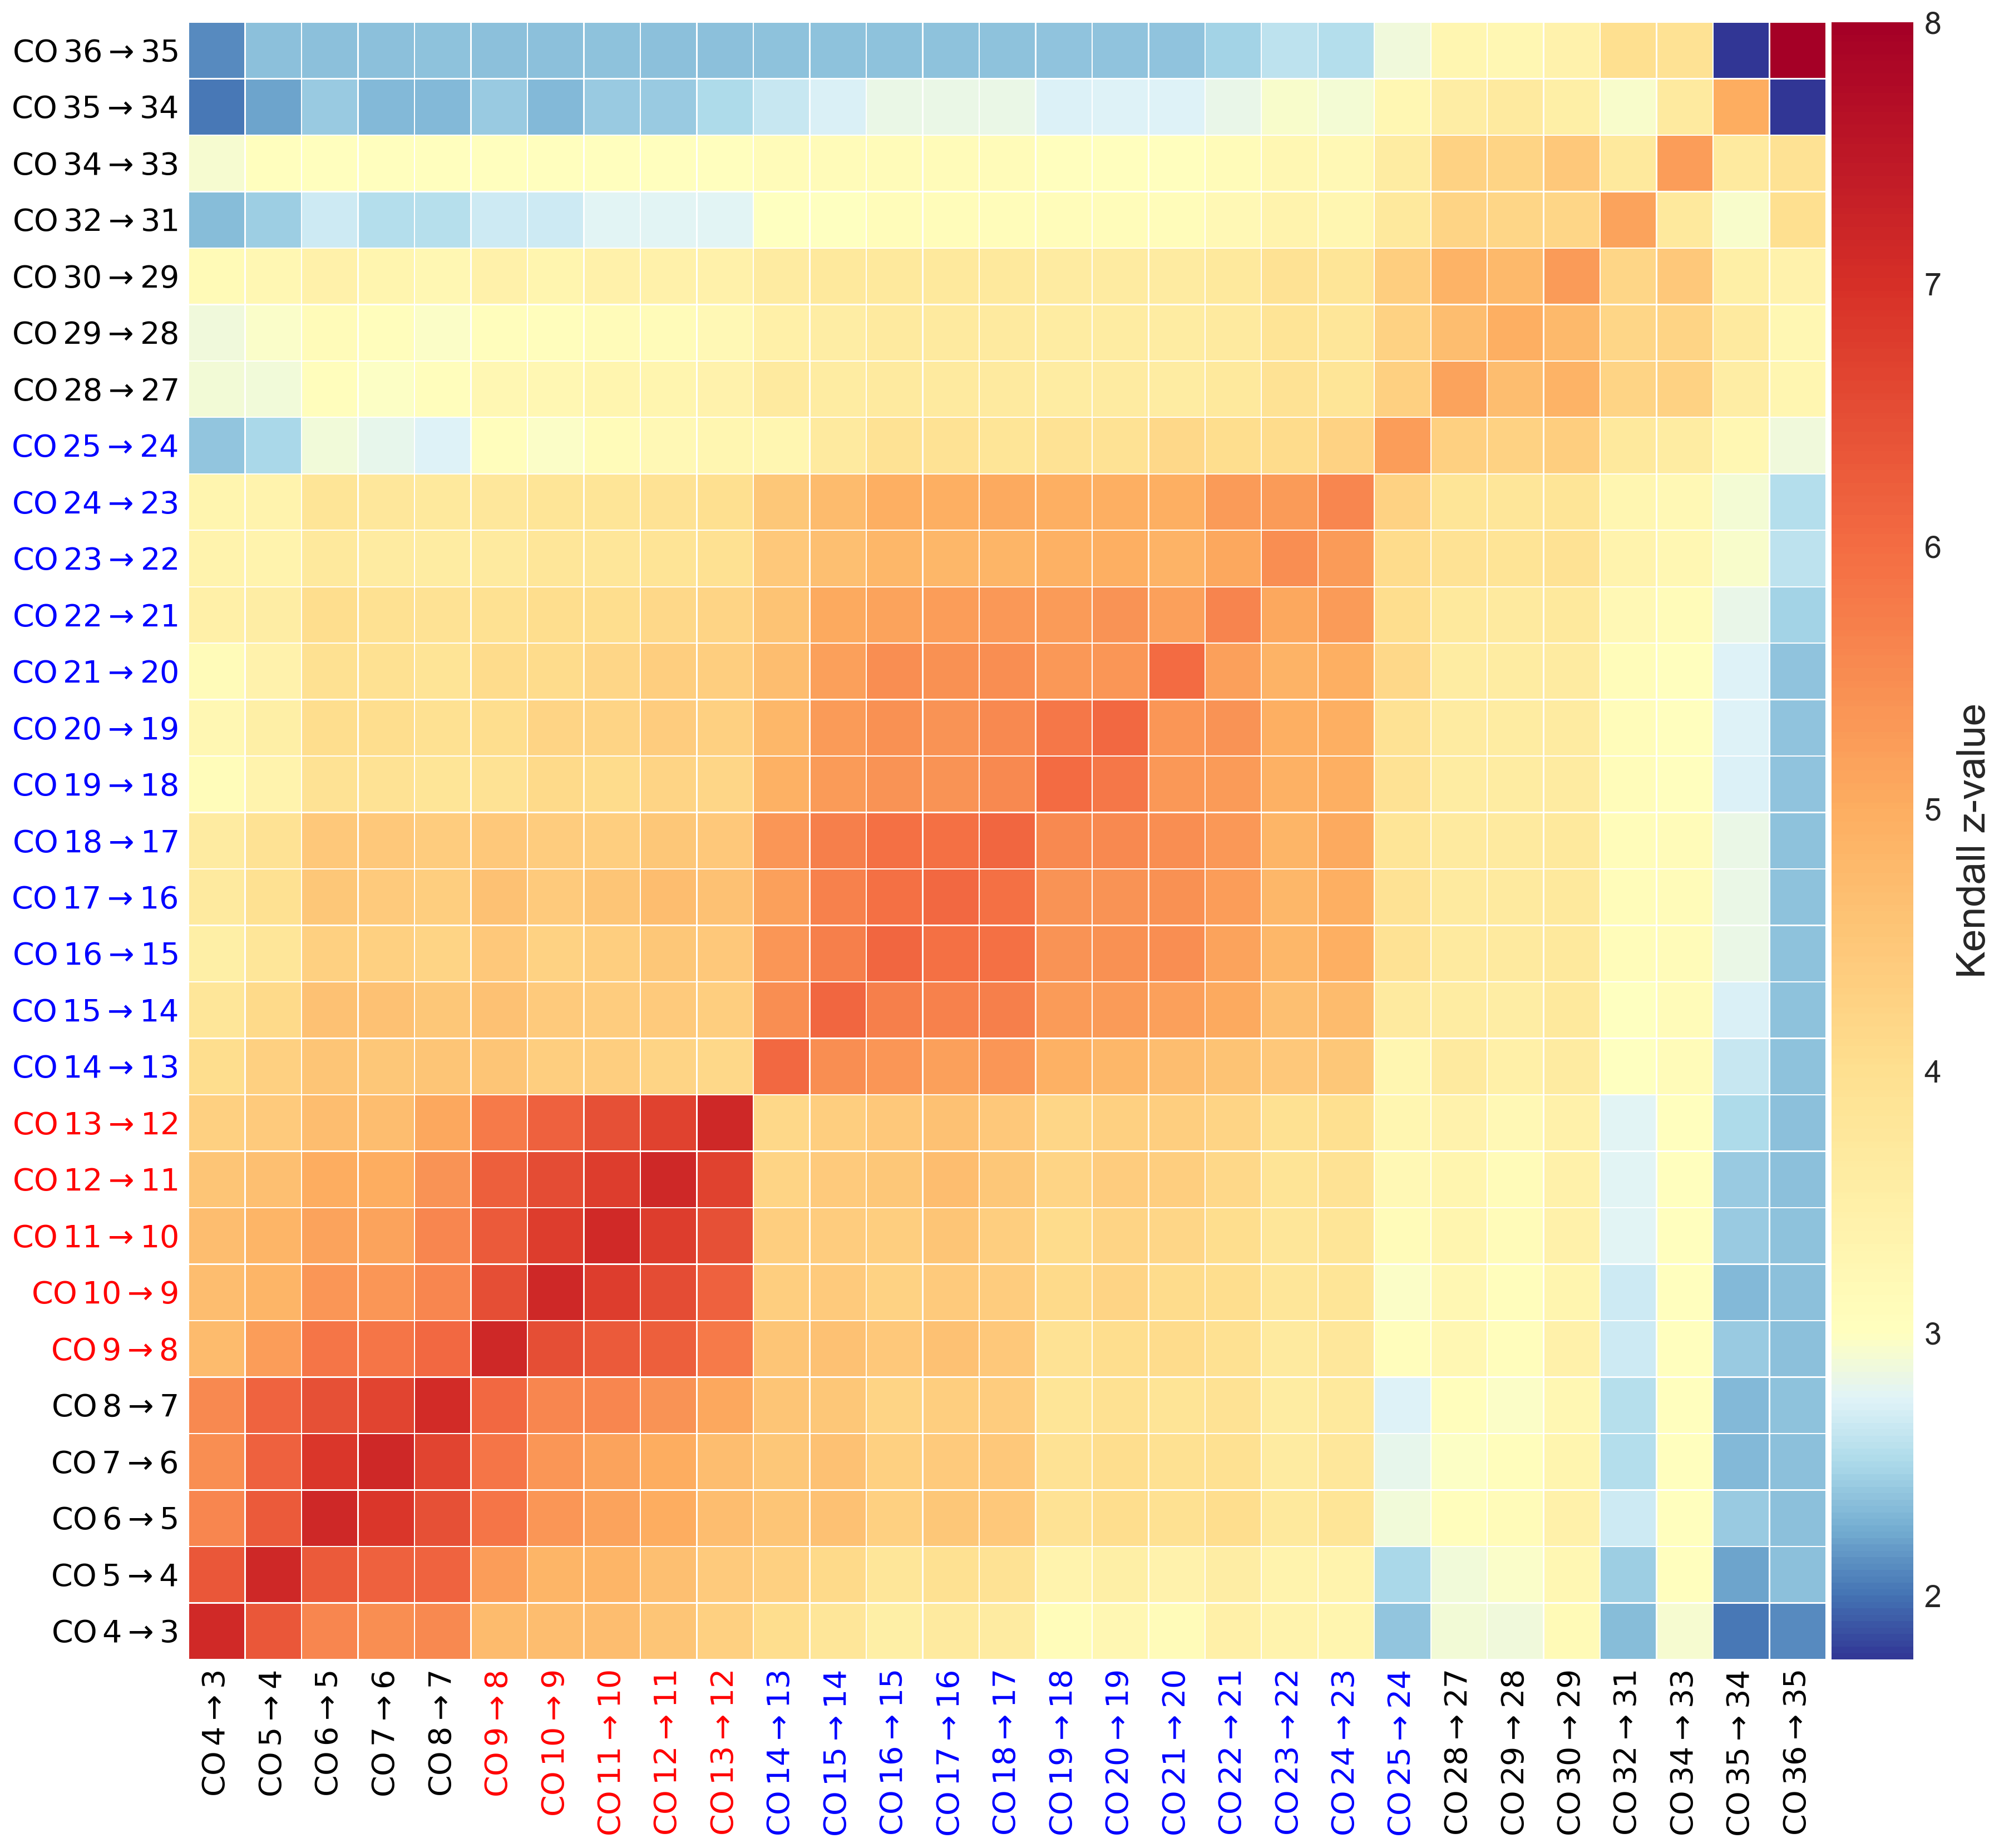

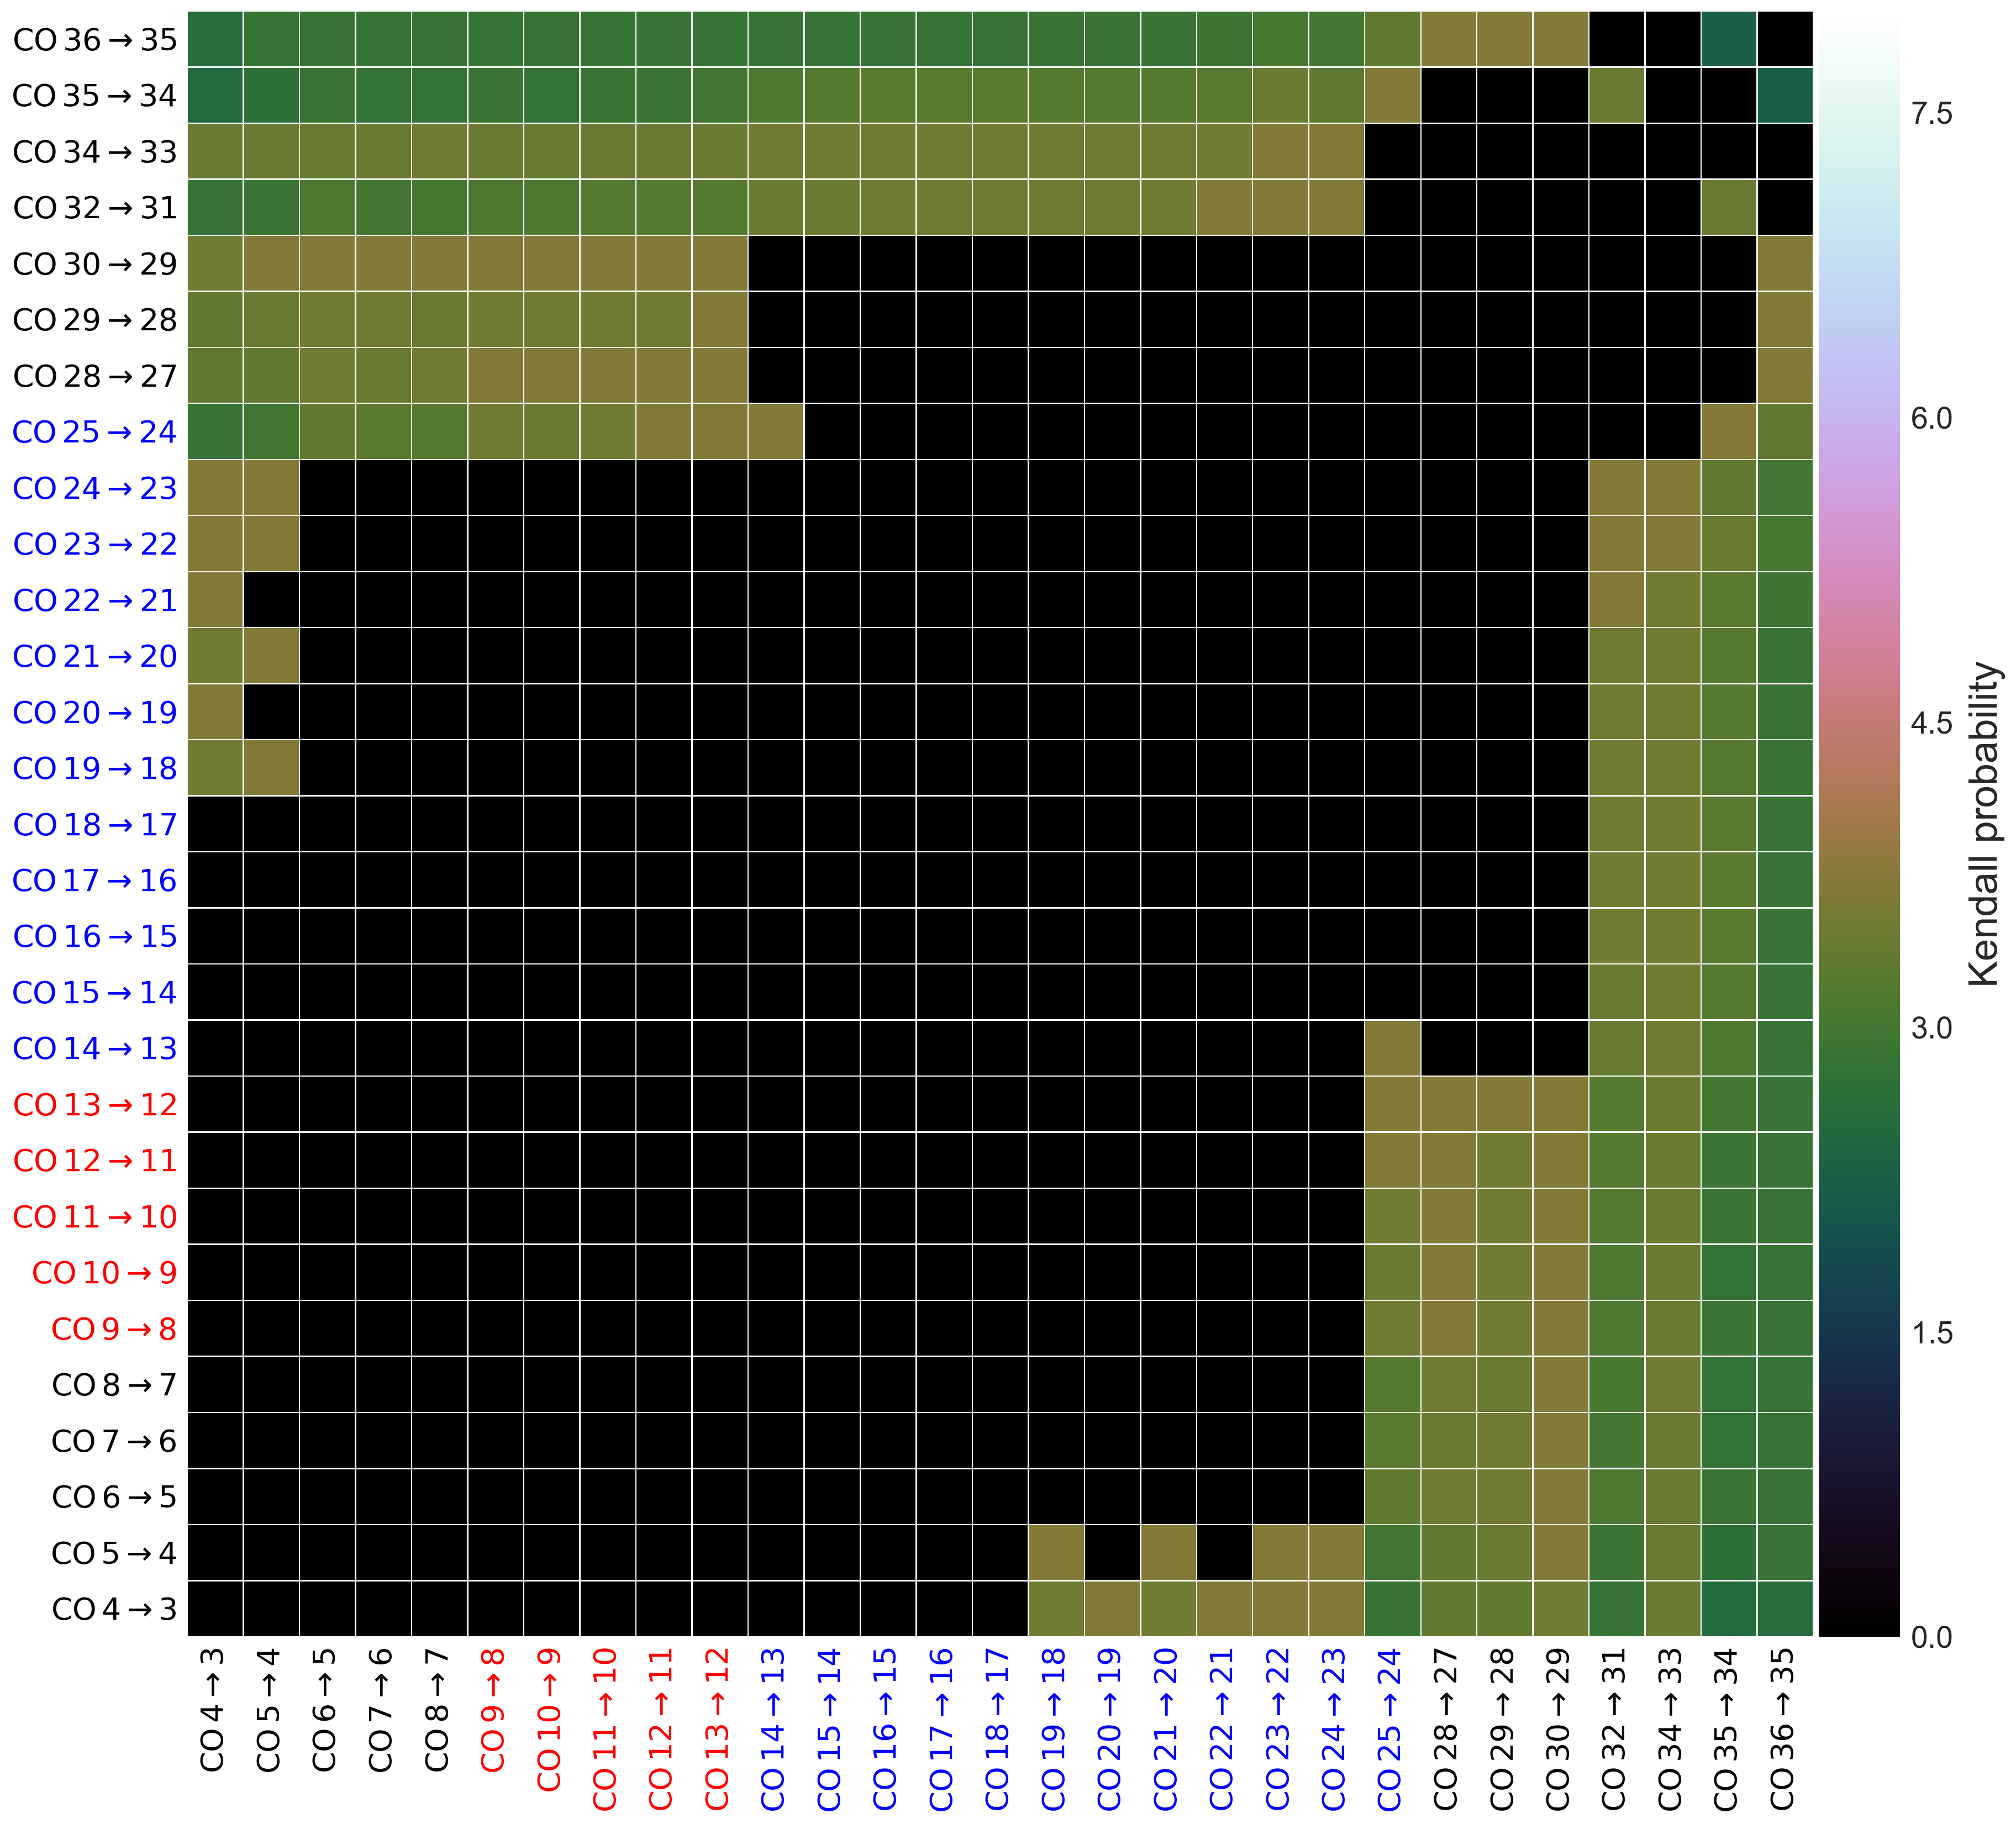

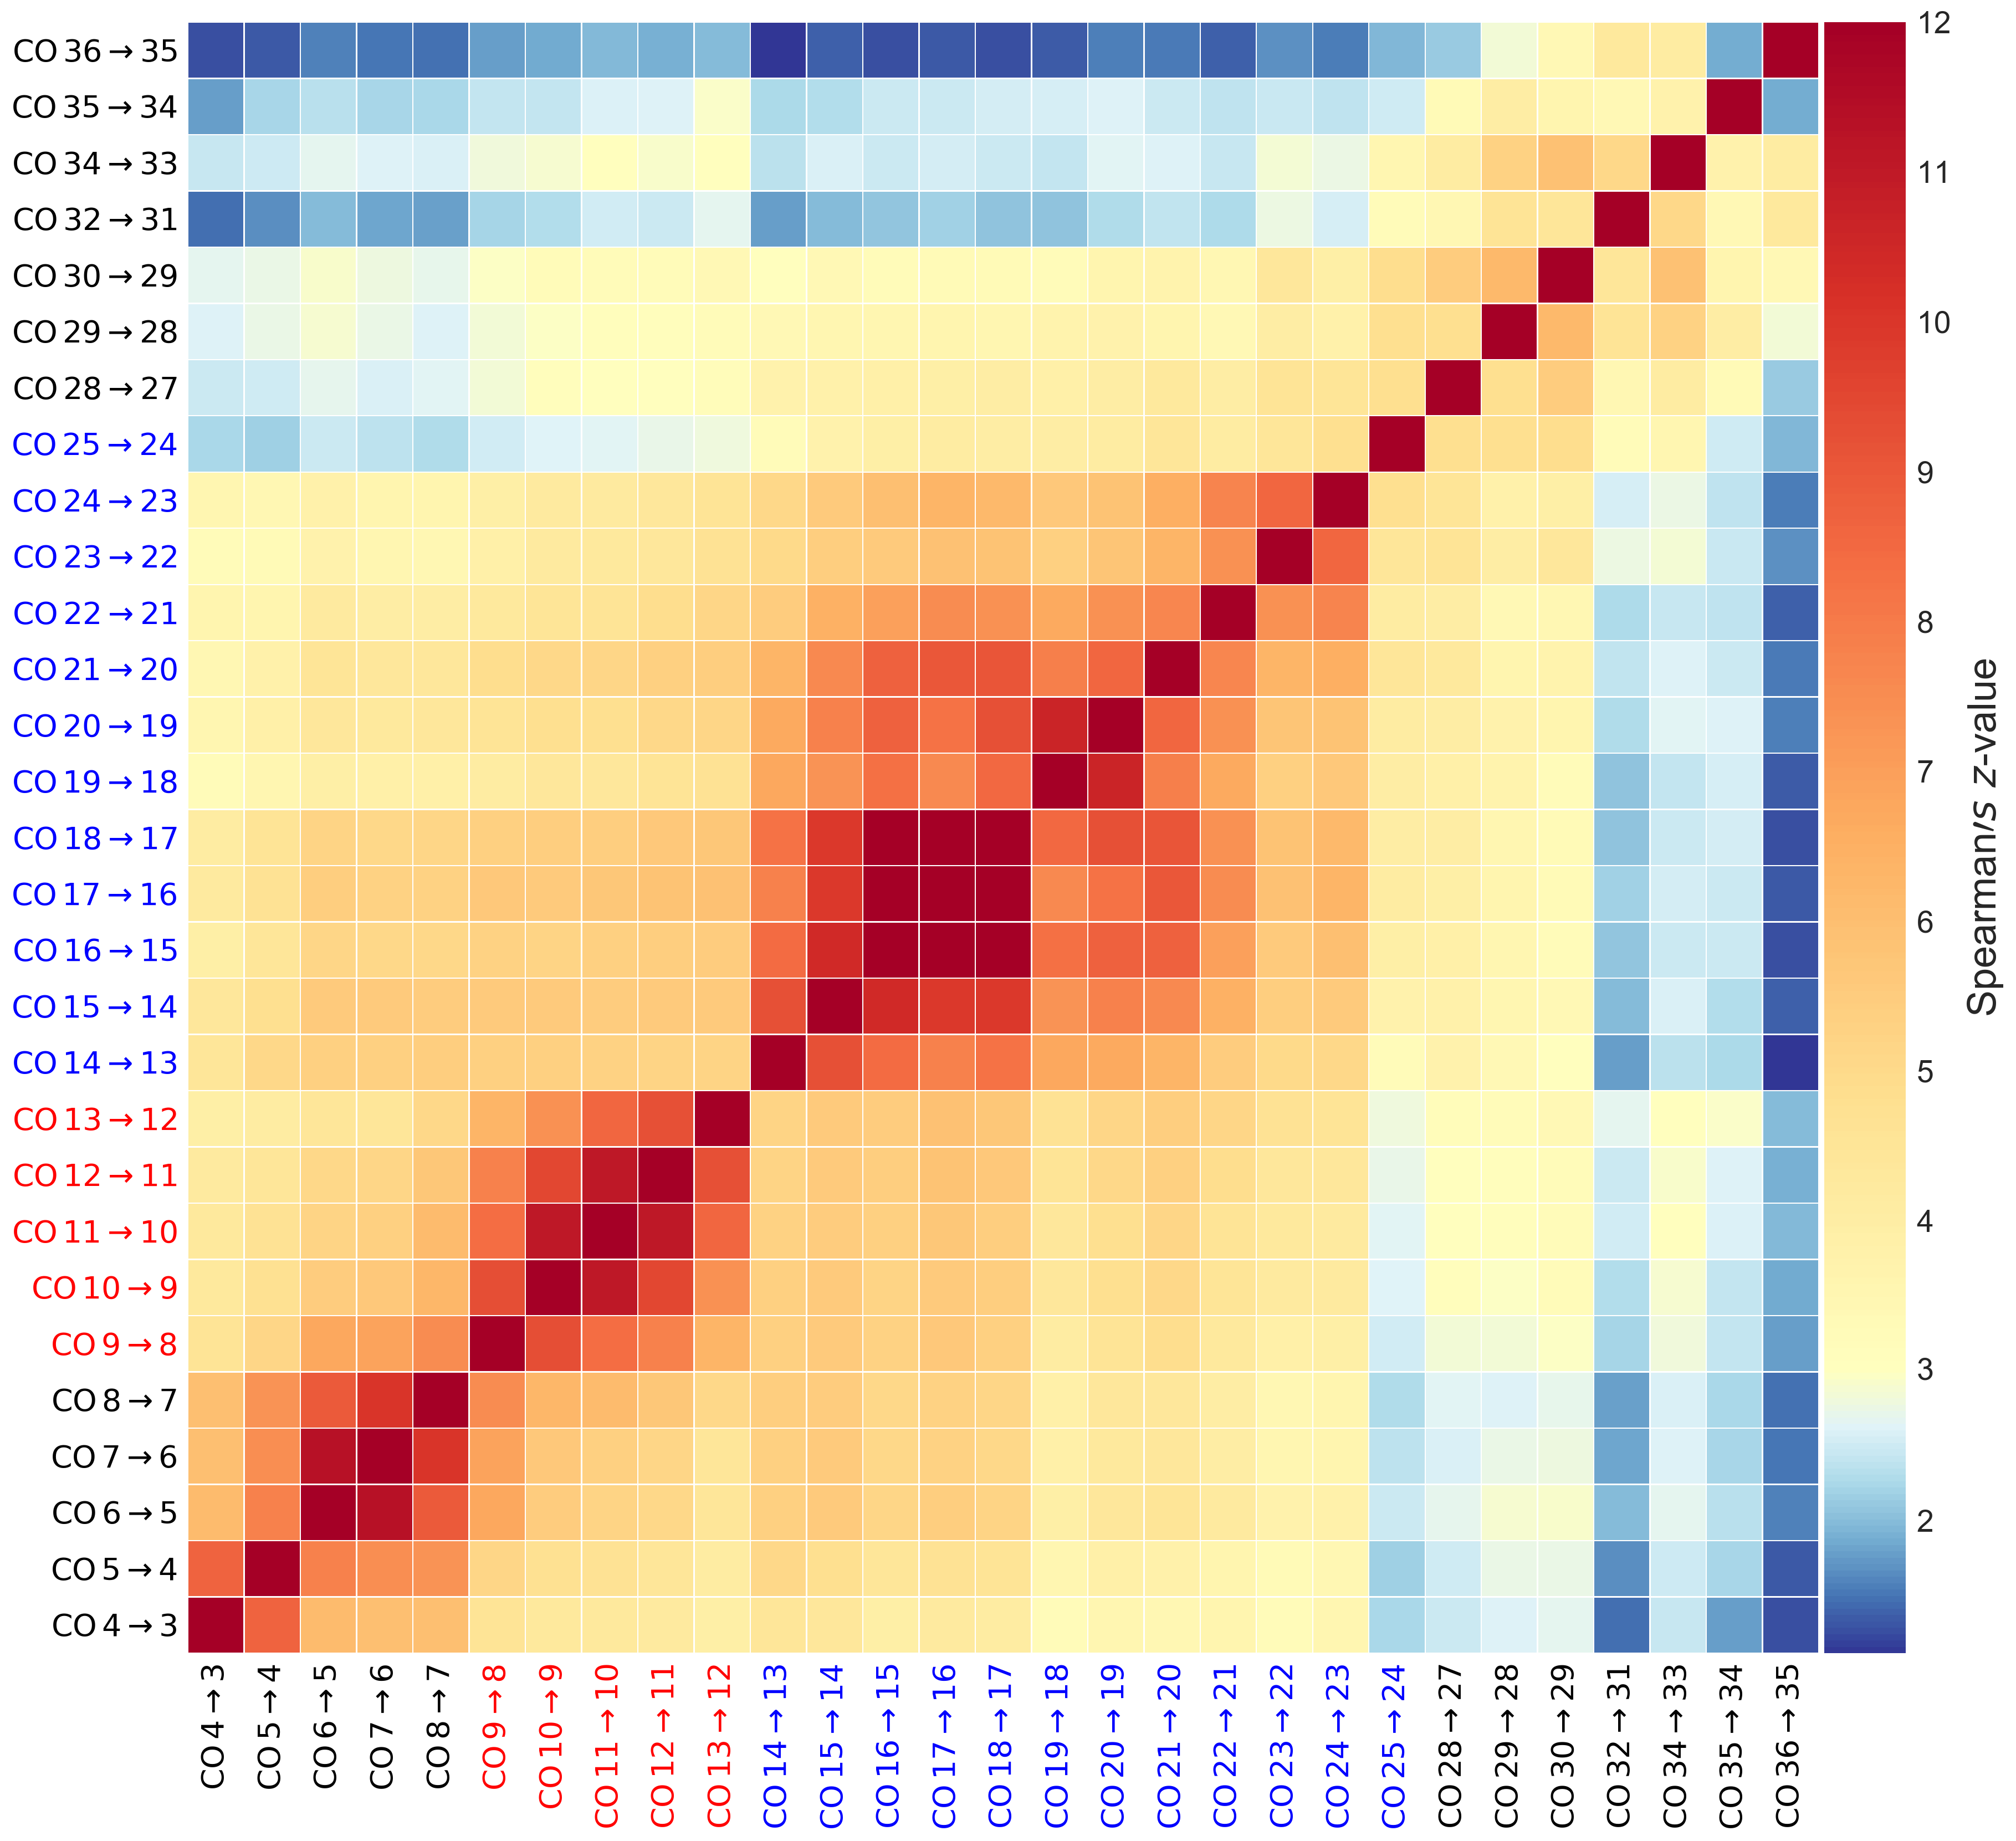

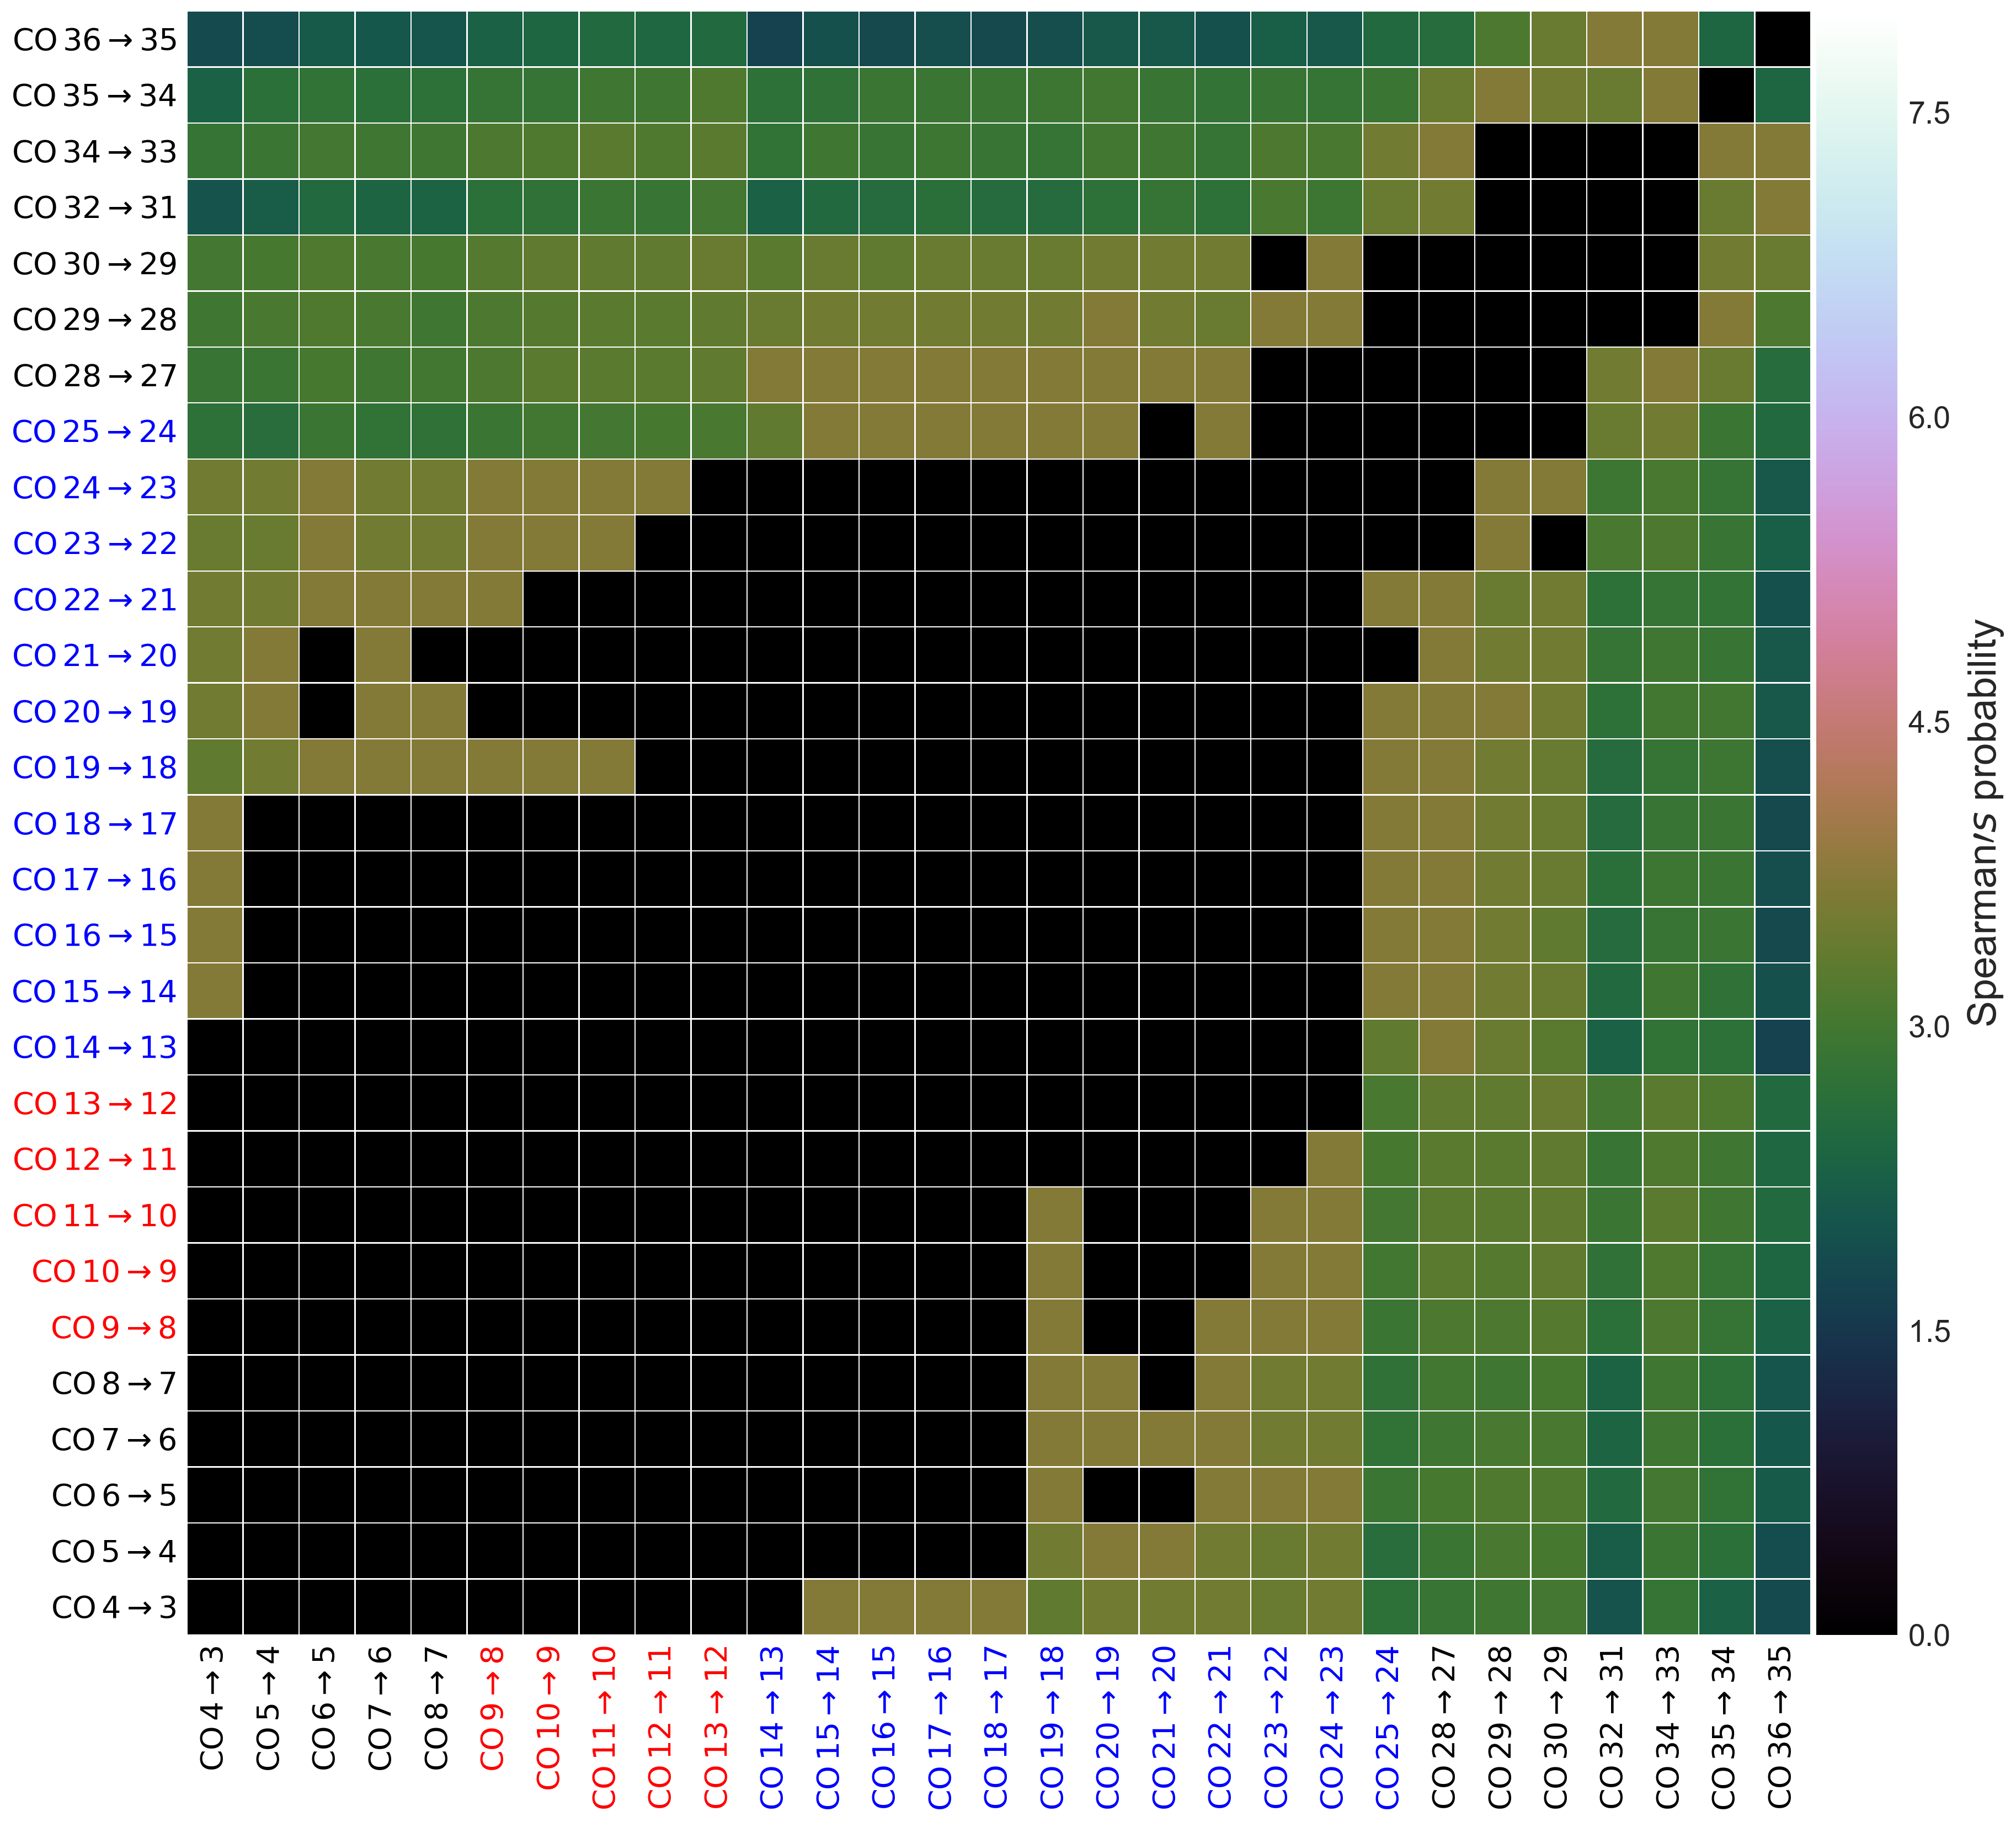

In [7]:
# only CO lines
col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
data = []
for i in range(len(col_name)):
    a = general_heatmap(line_list_co, col_name[i], corr_table, labels[i], line_labels=labels_co, suffix='_co')
    data.append(a)

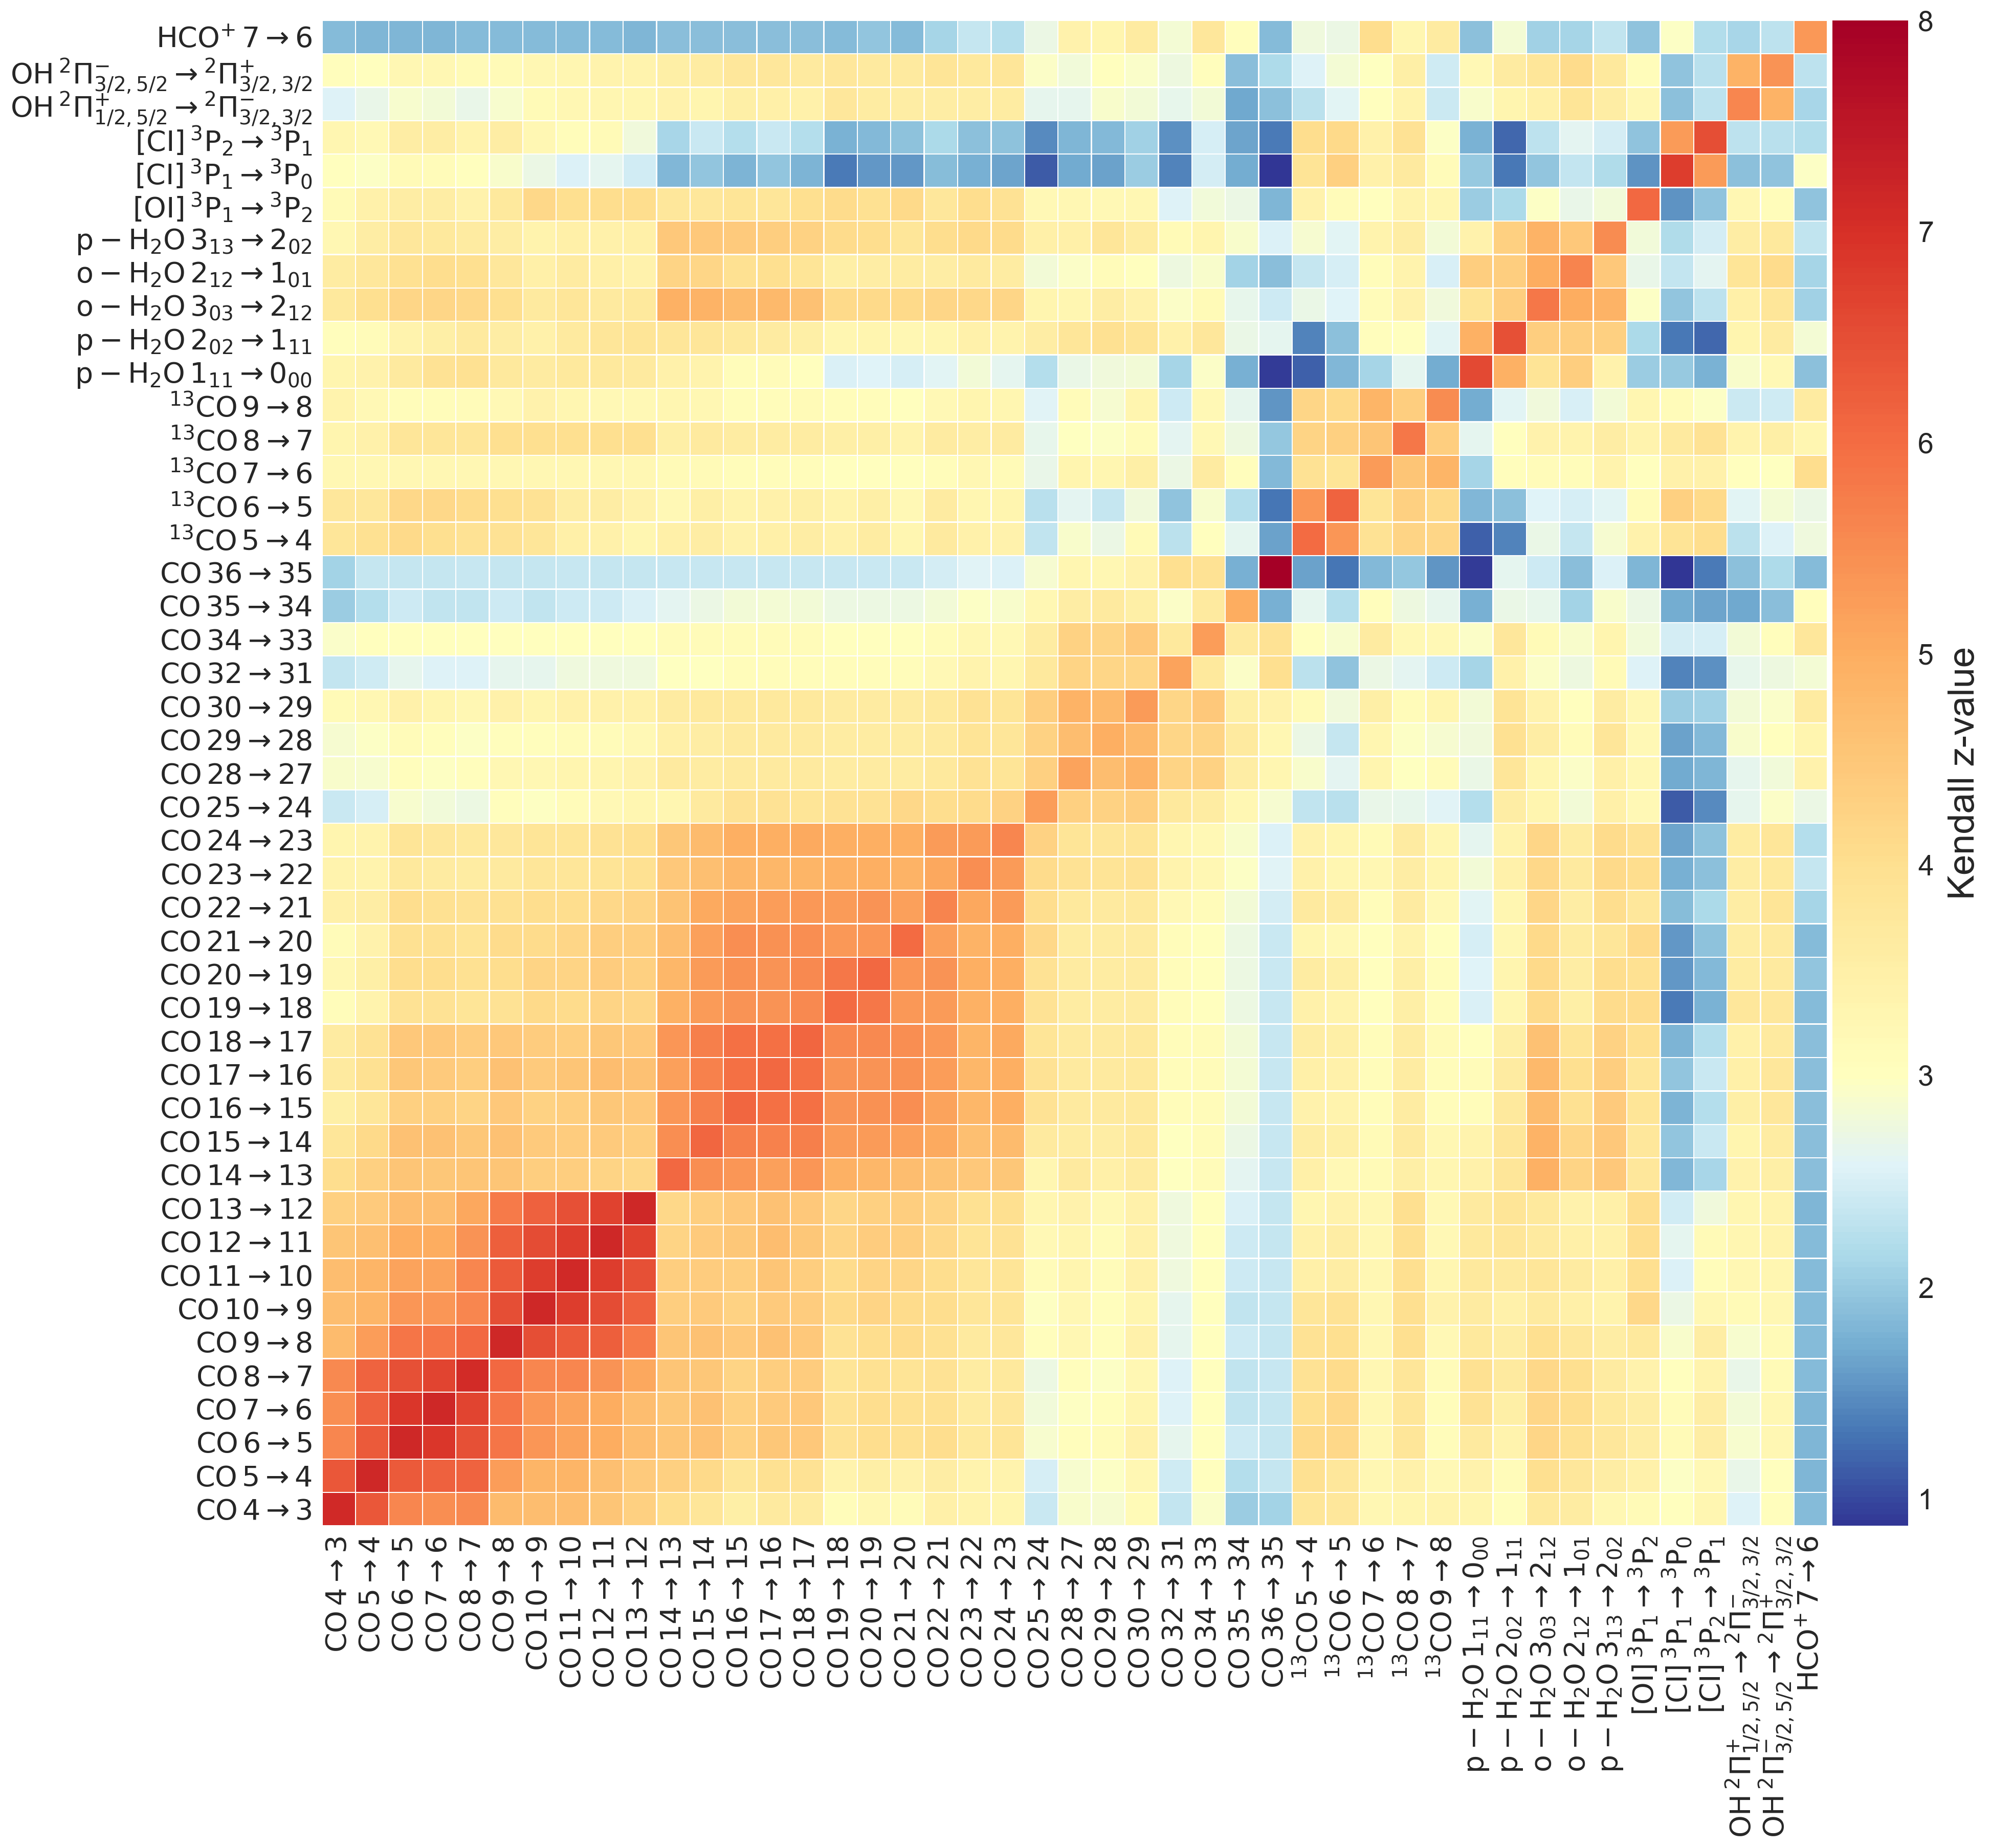

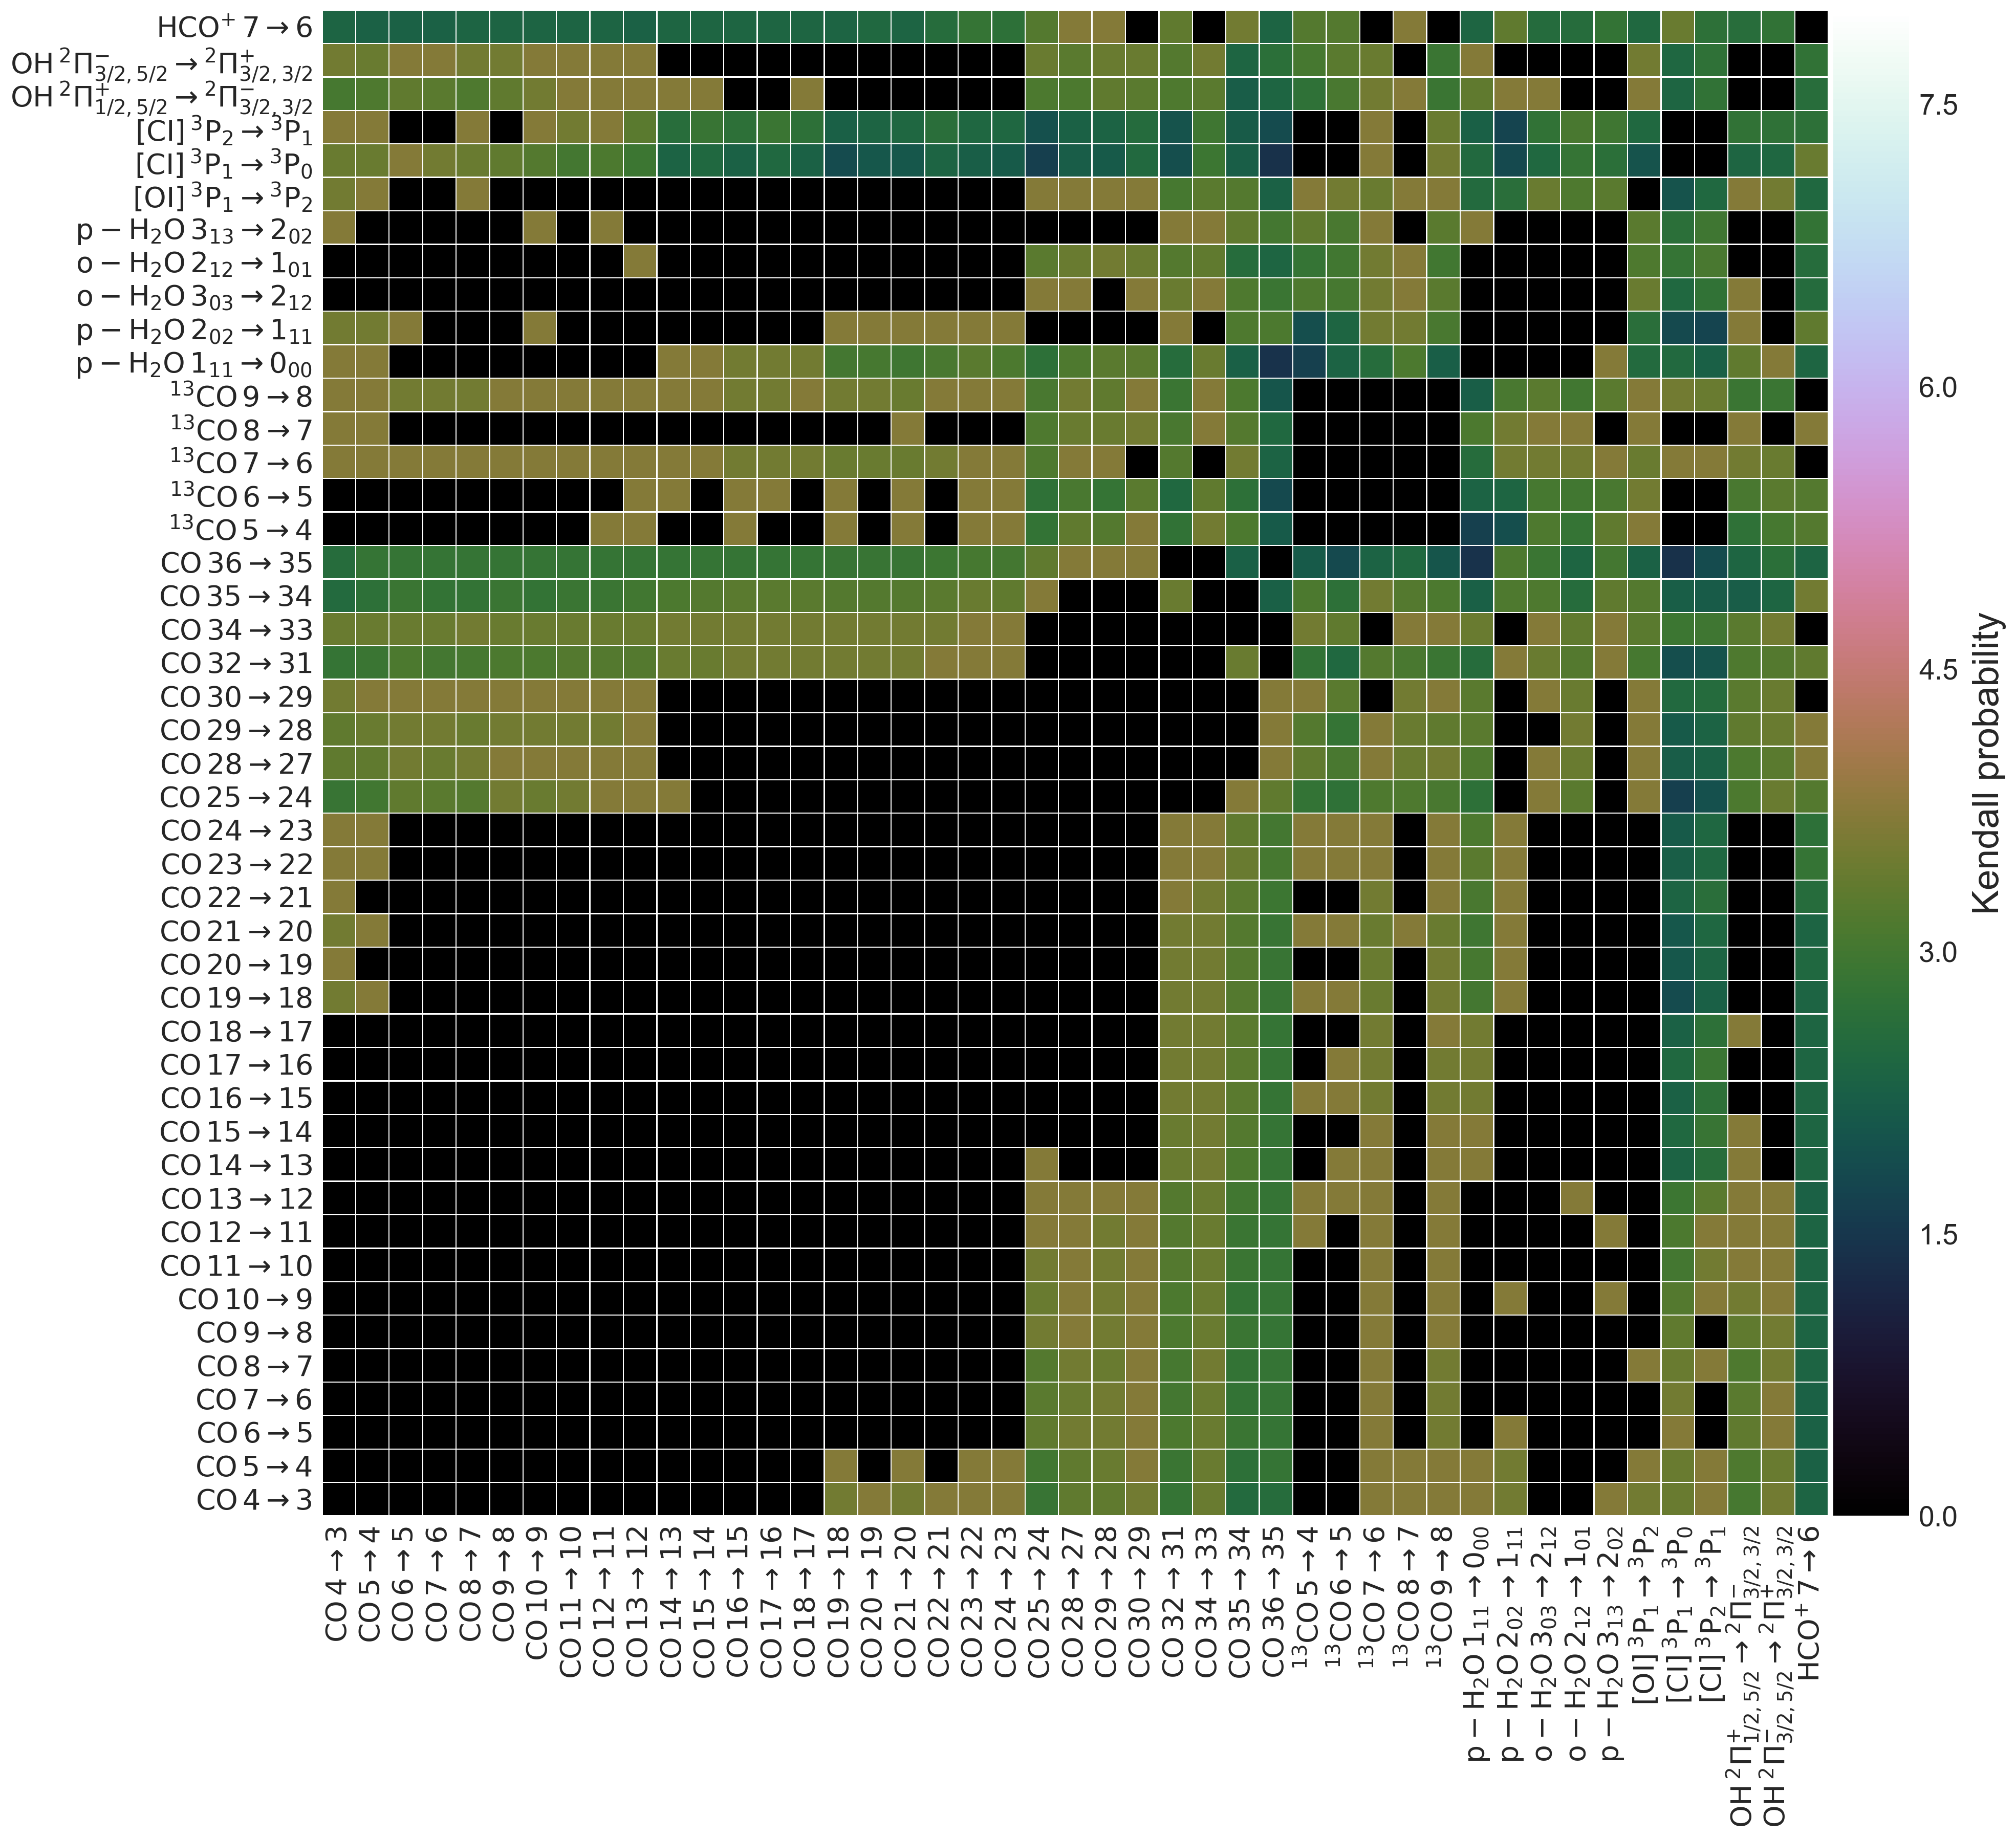

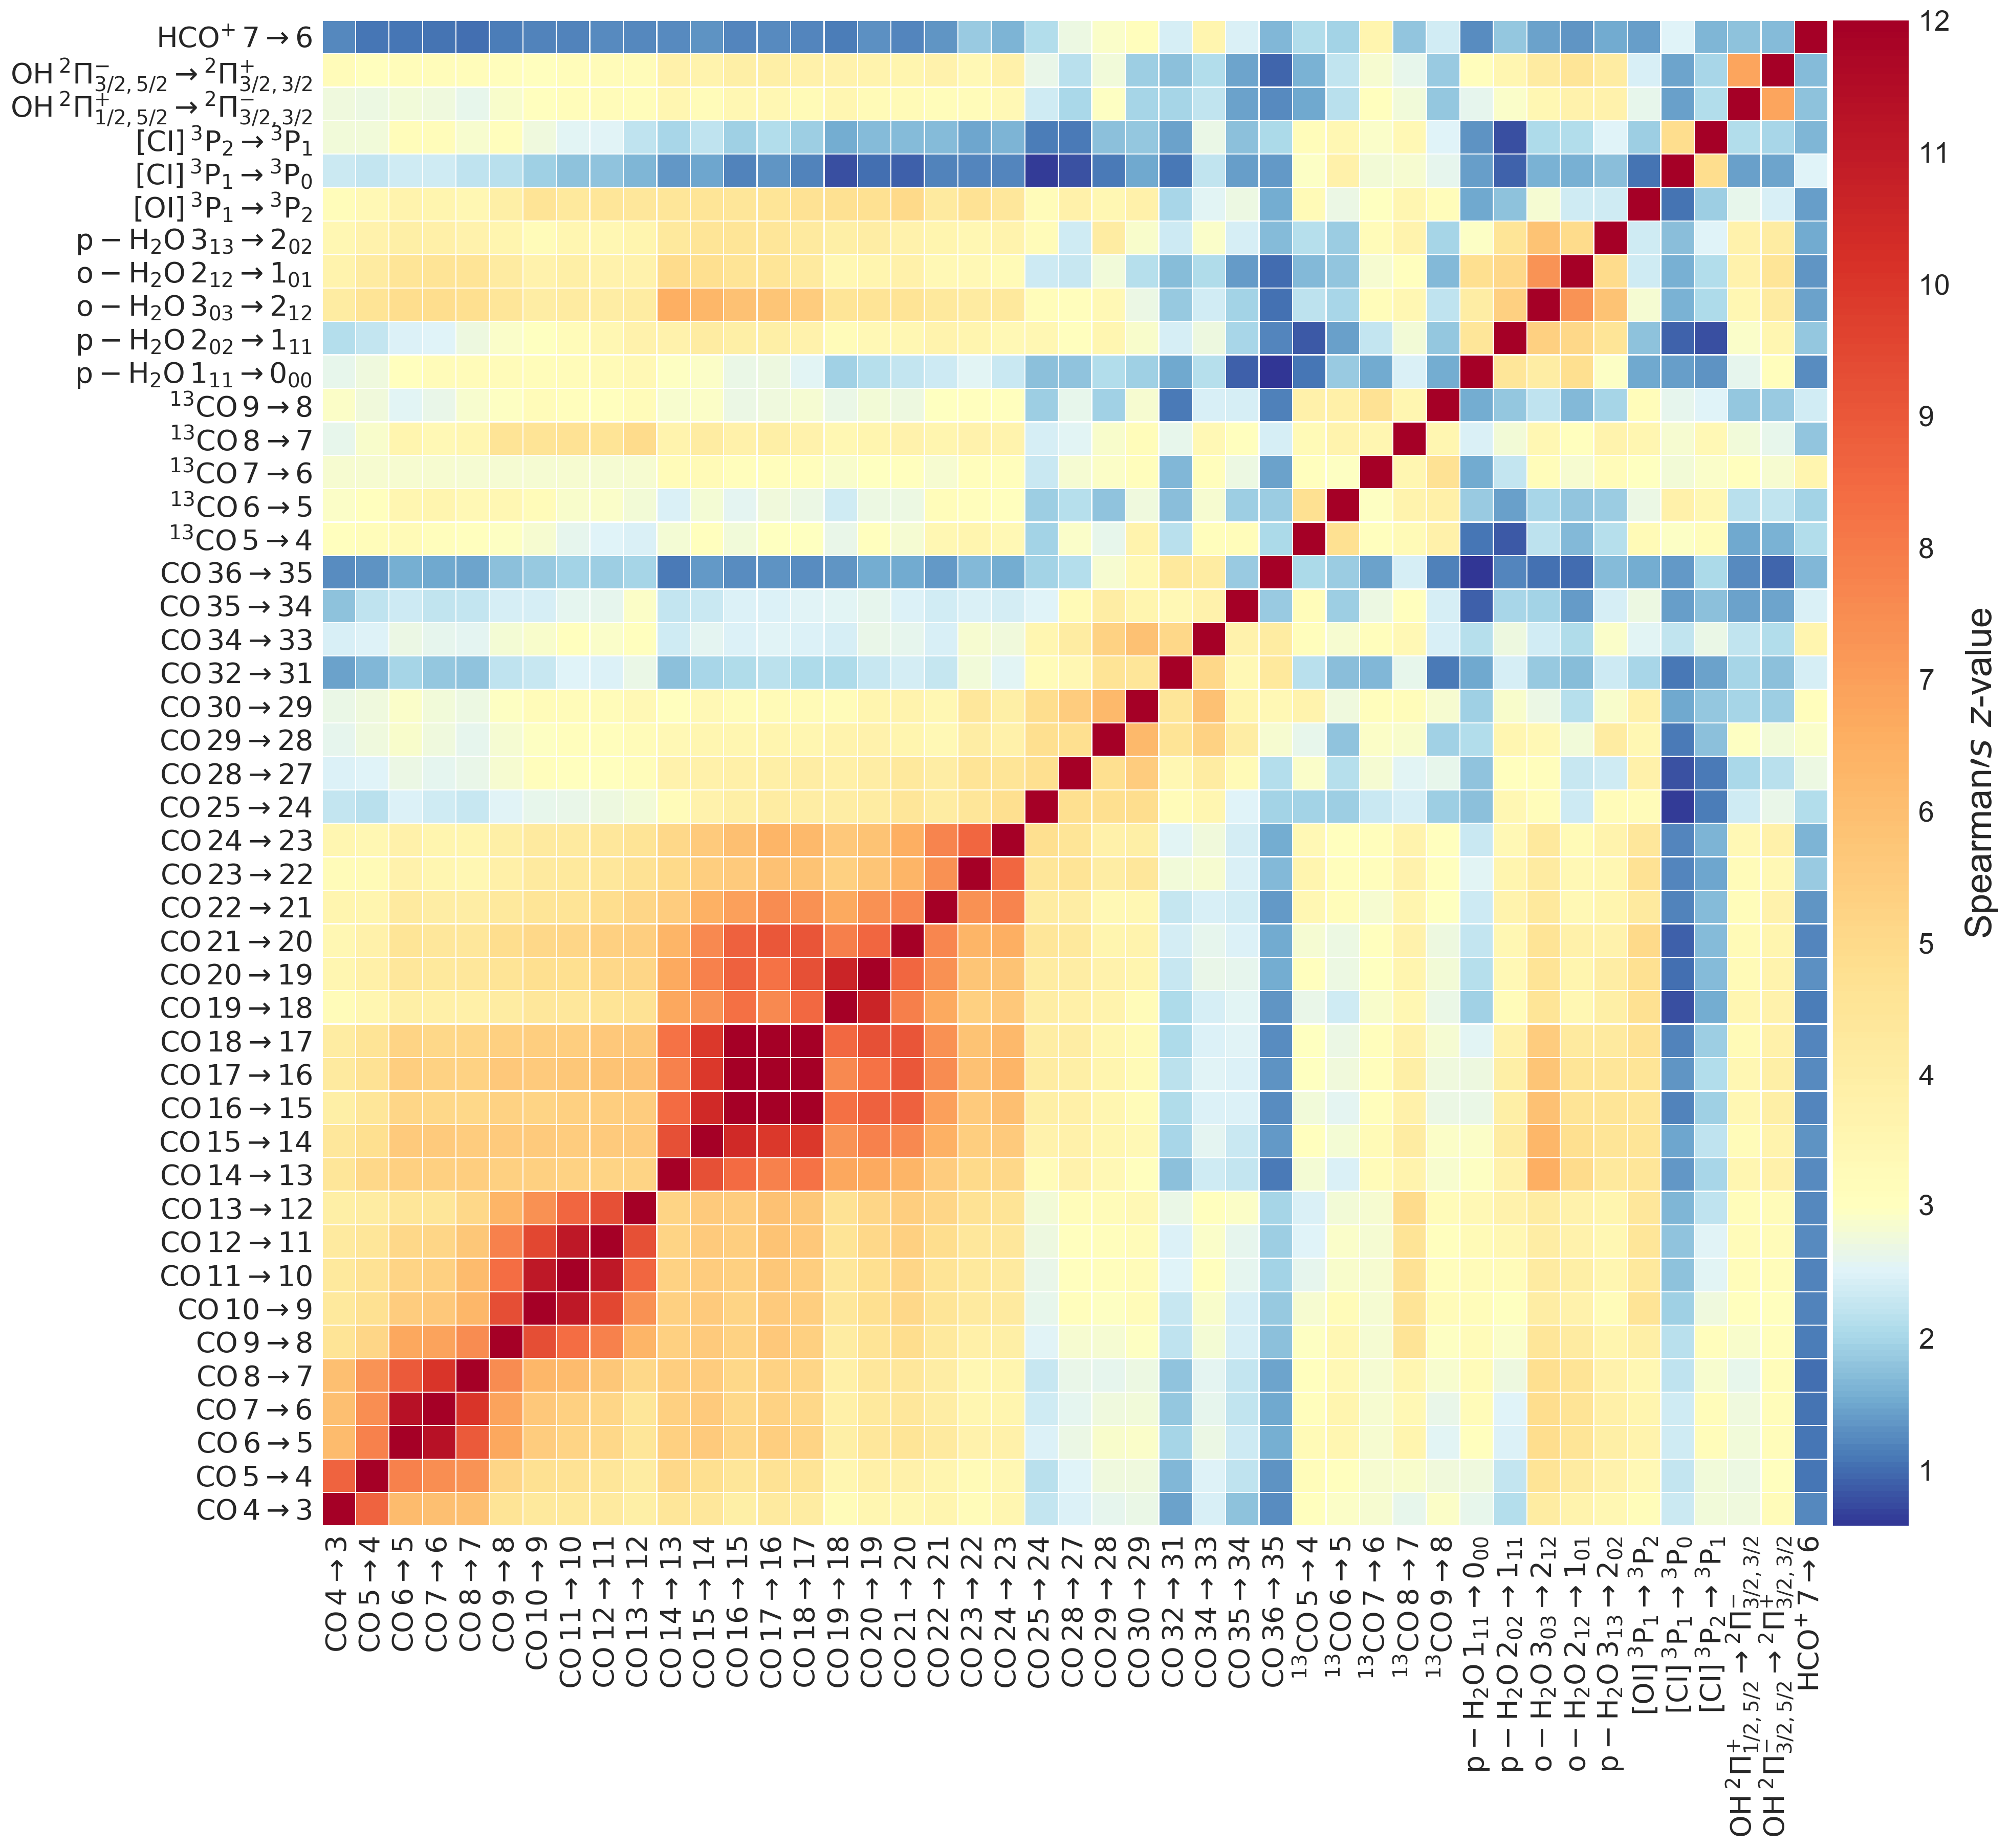

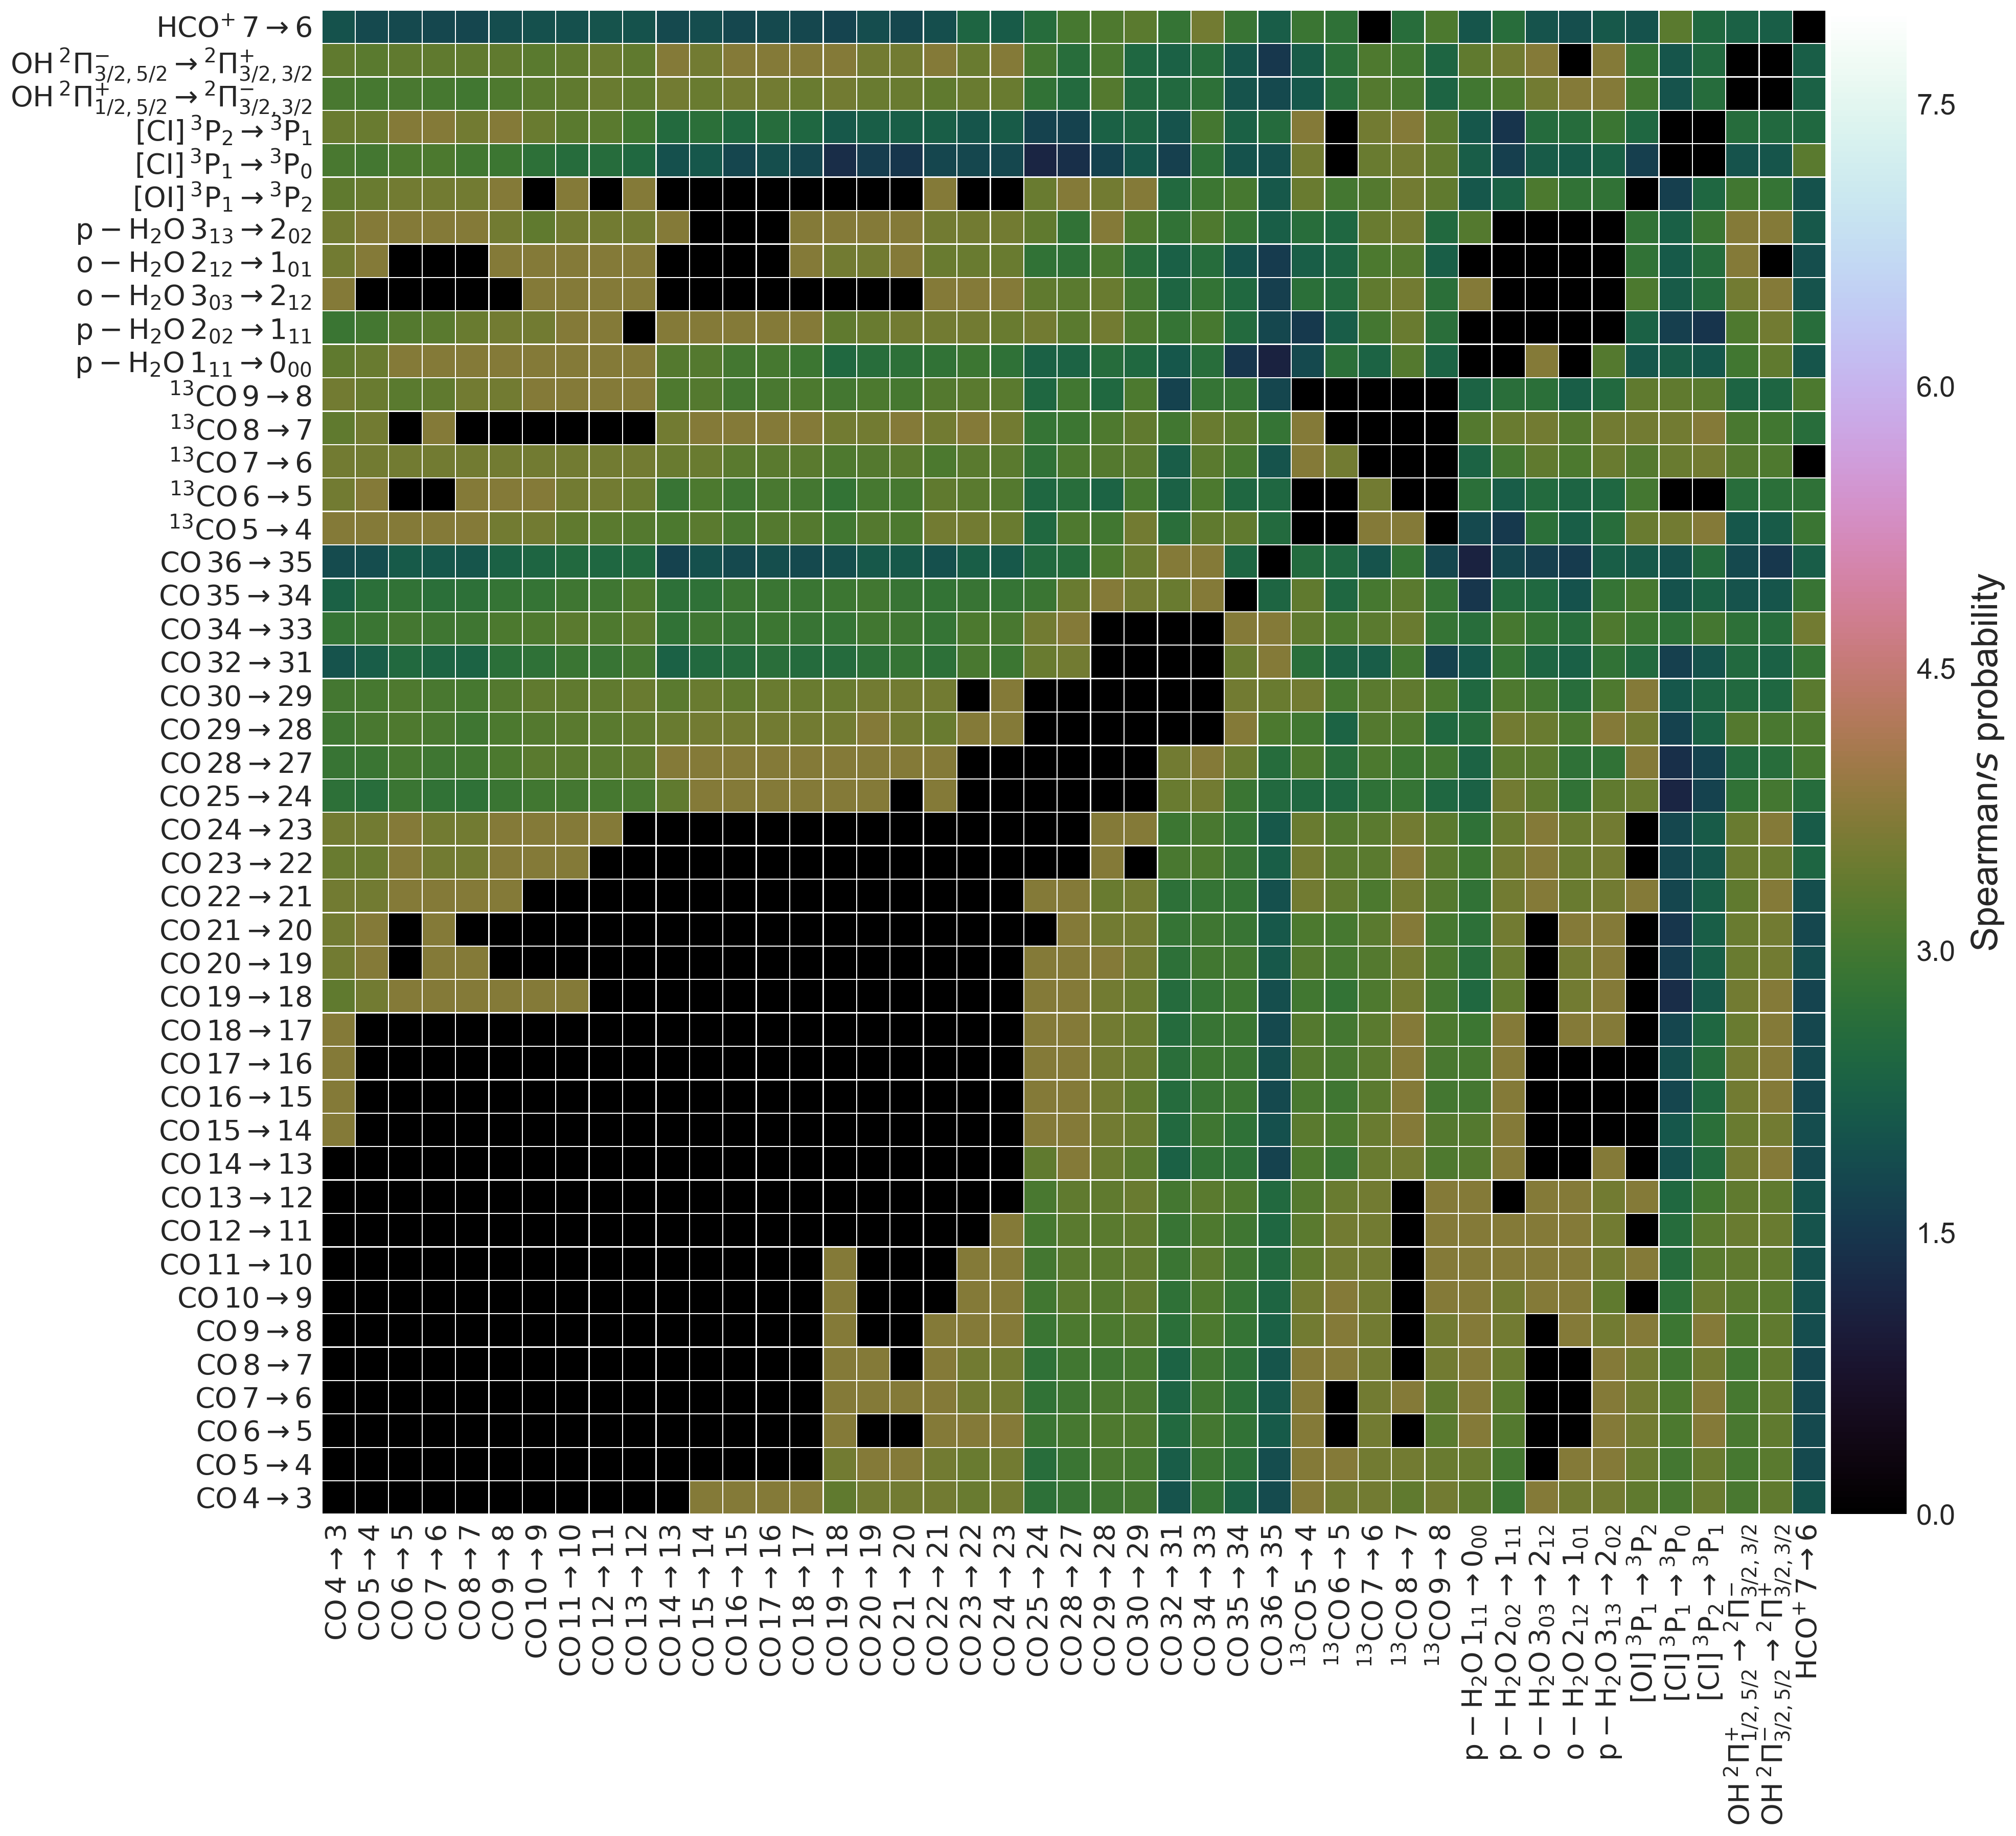

In [8]:
#wavelength sorter
# sorter = np.argsort(wave_list)
# all correlations
for i in range(len(col_name)):
    general_heatmap(line_list, col_name[i], corr_table, labels[i], line_labels=line_labels)

In [ ]:
mod_names = ['SSW','SLW','R1','B2B','B2A']
for mod in mod_names:
    for i in range(len(col_name)):
        general_heatmap(line_list[(wave_list >= module[mod][0]) & (wave_list < module[mod][1])],
                        col_name[i], corr_table, labels[i], mod_name=mod,
                        line_labels=line_labels[(wave_list >= module[mod][0]) & (wave_list < module[mod][1])])

### 1D distribution of correlation

/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide


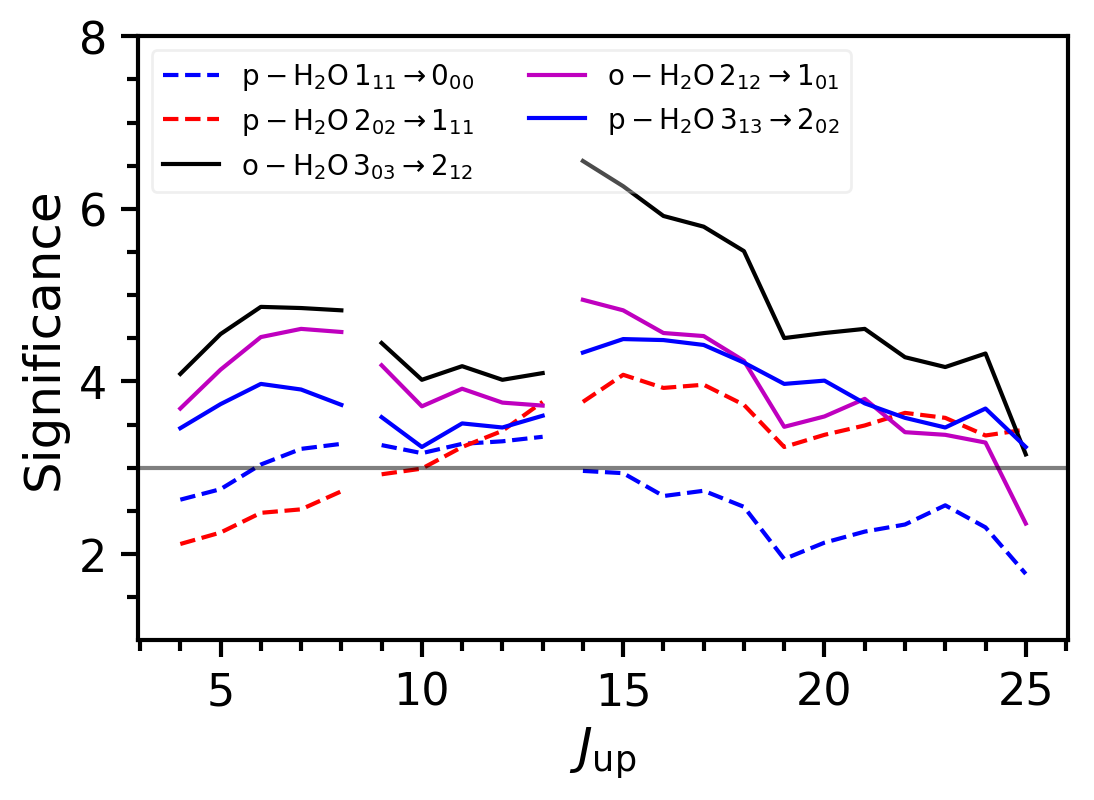

In [34]:
lines = ['p-H2O1_11-0_00','p-H2O2_02-1_11', 'o-H2O3_03-2_12','o-H2O2_12-1_01', 'p-H2O3_13-2_02', 'CO16-15']
lines_typeset = [r'$\rm p-H_{2}O\,1_{11} \rightarrow 0_{00}$', r'$\rm p-H_{2}O\,2_{02} \rightarrow 1_{11}$',
                 r'$\rm o-H_{2}O\,3_{03} \rightarrow 2_{12}$', r'$\rm o-H_{2}O\,2_{12} \rightarrow 1_{01}$',
                 r'$\rm p-H_{2}O\,3_{13}\rightarrow 2_{02}$', r'CO $J=16\rightarrow15$']

from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = ascii.read('/Users/yaolun/astro_tools/all_correlation.txt')
data['Spr.z'] =((20-3)/1.06)**0.5*0.5*np.log((1+data['Spr.rho'])/(1-data['Spr.rho']))

J_max = 25
J_min = 4

cor_1d = {}
for l in lines:
    cor_1d[l] = np.full(J_max-J_min+1, np.nan)
    select1 = data['Line1'] == l
    select2 = data['Line2'] == l
    
    if len(data['Line2'][select1]) != 0:
        for i, (co, d) in enumerate(zip(data['Line2'][select1], data['Spr.z'][select1])):
            if ('CO' in co) & ('HCO' not in co) & ('13CO' not in co):
                J_dum = co.split('CO')[1].split('-')[0]
                if int(J_dum) > J_max:
                    continue
                else:
                    cor_1d[l][int(J_dum)-J_min] = d

    if len(data['Line1'][select2]) != 0:
        for i, (co, d) in enumerate(zip(data['Line1'][select2], data['Spr.z'][select2])):
            if ('CO' in co) & ('HCO' not in co) & ('13CO' not in co):
                J_dum = co.split('CO')[1].split('-')[0]
                if int(J_dum) > J_max:
                    continue
                else:
                    cor_1d[l][int(J_dum)-J_min] = d 
                    
# plot
fig = plt.figure()
ax = fig.add_subplot(111)

J_ranges = [np.arange(J_min, 8+1), np.arange(9, 13+1), np.arange(14,J_max+1)]
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c', '#a6cee3', '#1f78b4']
colors = ['b','r','k','m','b','r']
linestyles = ['--','--','-','-','-','-']
all_J_range = np.arange(J_min, J_max+1)

for il, l in enumerate(lines):
    for i, j_range in enumerate(J_ranges):
        if i == 0:
            label=lines_typeset[lines.index(l)]
        else:
            label = ''
        if 'CO' in l:
            continue
            cor_1d[l] = cor_1d[l]*0.8
        ax.plot(j_range, cor_1d[l][(all_J_range >= j_range.min()) & (all_J_range <= j_range.max())],
                '-', color=colors[il], label=label, linestyle=linestyles[il], linewidth=1.5)

# ax.axvline(8.5, color='k')
# ax.axvline(13.5, color='k')
ax.axhline(3, color='k', alpha=0.5)

ax.set_ylim([1,8])    
ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=6)
ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=4)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.legend(loc='upper left', fontsize=10, ncol=2, framealpha=0.3)
ax.set_xlabel(r'$J_{\rm up}$', fontsize=18)
ax.set_ylabel('Significance', fontsize=18)

fig.savefig('/Volumes/SD-Mac/research/cops-spire/water_1d_correlations_with_co.pdf',
            format='pdf', dpi=300, bbox_inches='tight')